In [1]:
import os
os.chdir('/Users/gracelyons/Desktop/MSDS/Capstone/')
from speech_feature_extraction import *

/Users/gracelyons/opt/anaconda3/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
transcript_path = 'Transcripts/Teacher and Avatar/Temi Transcripts_02_16_23/'
wav_path = 'wav_files/wav_files/'

chunked_transcript_path = 'Transcripts/chunked/'
chunked_wav_path = 'wav_files/wav_files/chunked/'
chunked_teacher_wav_path = 'wav_files/wav_files/chunked_teacher/'

if not os.path.exists(chunked_wav_path):
    os.makedirs(chunked_wav_path)
    
if not os.path.exists(chunked_transcript_path):
    os.makedirs(chunked_transcript_path)

if not os.path.exists(chunked_teacher_wav_path):
    os.makedirs(chunked_teacher_wav_path)
    
file_list = os.listdir(wav_path)
file_list = [x.replace('.wav', '')for x in file_list if '.wav' in x]

print(len(file_list))

transript_file_list = [x.replace('.txt', '')for x in os.listdir(transcript_path) if '.txt' in x] 
for file in file_list:
    if file not in transript_file_list:
        print(file)

89


In [3]:
for file in file_list:
    chunk_wav_transcript_file(file, wav_path, transcript_path,
                             chunked_wav_path, chunked_transcript_path)

In [4]:
chunked_wav_file_list = [x.replace('.wav', '')for x in os.listdir(chunked_wav_path) if '.wav' in x] 

assert len(file_list)*5 == len(chunked_wav_file_list)

In [5]:
chunked_file_list = os.listdir(chunked_wav_path) 

In [6]:
chunked_file_list = [x.replace('.wav', '')for x in chunked_file_list if '.wav' in x]

In [7]:
chunked_transcripts = [x.replace('.txt', '') for x in os.listdir(chunked_transcript_path) if '.txt' in x]

In [8]:
len(chunked_transcripts)

445

In [9]:
import pandas as pd
import numpy as np
os.chdir('/Users/gracelyons/Desktop/MSDS/Capstone/Transcripts/chunked/')
from glob2 import glob

In [10]:
transcripts = [trans for trans in sorted(glob('*.txt'))]

In [11]:
speaker_1s = [218, 220, 314]
speaker_3s = [212, 325, 331, 335, 351, 258]
OHCO = ['speaker_id', 'line_num', 'sent_num', 'token_num']

In [12]:
transcripts[0]

'201_1.24.20_S_SC_Chunk_0.txt'

In [13]:
my_lib = []
my_doc = []

for transcript in transcripts:
    speaker_id = transcript.split('_')[0].replace('th', '') + '_' + transcript.split('_')[-1].replace('.txt', '')
    
    df = pd.read_csv(transcript, engine = 'python', delimiter = '\t', header = None)
    df.columns = ['Speaker', 'Timestamp', 'line_str']
    df.line_str = df.line_str.str.strip()
    df['speaker_id'] = speaker_id
    df.index.name = 'line_num'
    
    if speaker_id in speaker_1s:
        df = df[df.Speaker == 'Speaker 1:']
    elif speaker_id in speaker_3s:
        df = df[df.Speaker == 'Speaker 3:']
    else:
        df = df[df.Speaker == 'Speaker 2:']
        
    df = df.groupby(OHCO[:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame()
    
    df.index.names = OHCO[:-2]
    
    my_lib.append((speaker_id, transcript))
    my_doc.append(df)

In [14]:
docs = pd.concat(my_doc)
docs

line_str
speaker_id line_num                                                   
201_0      1         Good morning class. I'm Ms. Tachi. How are you...
           3         Good. That's good to hear. So today we're gonn...
201_1      0         Yeah. Good. Emily, Carlos, you guys Nice. So w...
201_2      0         Okay. Um, Emily, um, after small group, we can...
           2         No worries. Yeah, we can talk about it. Um, Ca...
...                                                                ...
360_4      4                   Tell us about what happened over break.
           6                                   Well, you know, we have
           8         To talk and No, for the record, definitely don...
           10                                                     This
           12        Because, well, it may seem boring. It never fe...

[2014 rows x 1 columns]

In [15]:
lib = pd.DataFrame(my_lib, columns = ['speaker_id', 'book_file']).set_index('speaker_id')
lib

book_file
speaker_id                              
201_0       201_1.24.20_S_SC_Chunk_0.txt
201_1       201_1.24.20_S_SC_Chunk_1.txt
201_2       201_1.24.20_S_SC_Chunk_2.txt
201_3       201_1.24.20_S_SC_Chunk_3.txt
201_4       201_1.24.20_S_SC_Chunk_4.txt
...                                  ...
360_0            360_3.16.22_Chunk_0.txt
360_1            360_3.16.22_Chunk_1.txt
360_2            360_3.16.22_Chunk_2.txt
360_3            360_3.16.22_Chunk_3.txt
360_4            360_3.16.22_Chunk_4.txt

[445 rows x 1 columns]

In [16]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

ws = False 
def word_tokenize(x):
    if ws:
        s = pd.Series(nltk.pos_tag(tokenizer.tokenize(x))) 
    else:
        s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
    return s

In [17]:
tokens = docs.line_str.apply(lambda x: pd.Series(nltk.sent_tokenize(x))).stack().to_frame().rename(columns = {0: 'sent_str'})
tokens = tokens.sent_str.apply(word_tokenize).stack().to_frame().rename(columns = {0: 'pos_tuple'})
tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
tokens.index.names = OHCO
tokens['term_str'] = tokens['token_str'].str.lower().str.replace('[\W_]', '')
tokens = tokens[tokens.term_str != '']

/var/folders/d6/7xmpr3_94p95d20njgyryt3m0000gn/T/ipykernel_11495/2858646896.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  tokens['term_str'] = tokens['token_str'].str.lower().str.replace('[\W_]', '')


In [18]:
tokens.head()

pos_tuple  pos token_str term_str
speaker_id line_num sent_num token_num                                       
201_0      1        0        0             (Good, JJ)   JJ      Good     good
                             1          (morning, NN)   NN   morning  morning
                             2            (class, NN)   NN     class    class
                    1        0               (I, PRP)  PRP         I        i
                             1              ('m, VBP)  VBP        'm        m

In [19]:
vocab = tokens.term_str.value_counts().to_frame()\
        .rename(columns = {'index': 'term_str', 'term_str': 'n'}).sort_index().reset_index()\
        .rename(columns = {'index': 'term_str'})
vocab.index.name = 'term_id'
vocab['num'] = vocab.term_str.str.match("\d+").astype('int')

sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns = ['term_str'])\
        .reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
        
vocab['stop'] = vocab.term_str.map(sw.dummy).fillna(0).astype('int')

stems = [PorterStemmer(), SnowballStemmer('english'), LancasterStemmer()]    
for i, stem in enumerate(stems):
    str_stem = str(stems[i]).split('Stemmer')[0].split('.')[-1].replace('<', '').lower()
    vocab['stemmer_' + str_stem] = vocab.term_str.apply(stem.stem)
    
tokens['term_id'] = tokens.term_str.map(vocab.reset_index().set_index('term_str').term_id)
vocab['pos_max'] = tokens.groupby(['term_id', 'pos']).count().iloc[:,0].unstack().idxmax(1)
    
vocab = vocab.sort_values('n', ascending = False).reset_index()
vocab.index.name = 'term_rank'
vocab = vocab.reset_index().set_index('term_id')
vocab['term_rank'] = vocab['term_rank'] + 1
vocab['p'] = vocab.n/vocab.n.sum() # prior, or marginal, probability of a term
vocab['h'] = vocab.p * np.log2(1/vocab.p) # self entropy of each word

In [20]:
vocab.head()

term_rank term_str     n  num  stop stemmer_porter stemmer_snowball  \
term_id                                                                        
1469             1       we  1562    0     1             we               we   
1536             2      you  1479    0     1            you              you   
1323             3     that  1433    0     1           that             that   
1359             4       to  1397    0     1             to               to   
618              5        i  1030    0     1              i                i   

        stemmer_lancaster pos_max         p         h  
term_id                                                
1469                   we     PRP  0.034510  0.167610  
1536                  you     PRP  0.032676  0.161278  
1323                 that      DT  0.031660  0.157705  
1359                   to      TO  0.030865  0.154876  
618                     i     PRP  0.022756  0.124195

In [21]:
token = tokens
token.head()

pos_tuple  pos token_str term_str  \
speaker_id line_num sent_num token_num                                          
201_0      1        0        0             (Good, JJ)   JJ      Good     good   
                             1          (morning, NN)   NN   morning  morning   
                             2            (class, NN)   NN     class    class   
                    1        0               (I, PRP)  PRP         I        i   
                             1              ('m, VBP)  VBP        'm        m   

                                        term_id  
speaker_id line_num sent_num token_num           
201_0      1        0        0              538  
                             1              828  
                             2              230  
                    1        0              618  
                             1              766

### PCA

In [22]:
os.chdir('/Users/gracelyons/Desktop/MSDS/Capstone/')

In [23]:
merged = token.reset_index().merge(lib.reset_index(), how = 'left', on = 'speaker_id') 

In [24]:
merged.head()

speaker_id  line_num  sent_num  token_num      pos_tuple  pos token_str  \
0      201_0         1         0          0     (Good, JJ)   JJ      Good   
1      201_0         1         0          1  (morning, NN)   NN   morning   
2      201_0         1         0          2    (class, NN)   NN     class   
3      201_0         1         1          0       (I, PRP)  PRP         I   
4      201_0         1         1          1      ('m, VBP)  VBP        'm   

  term_str  term_id                     book_file  
0     good      538  201_1.24.20_S_SC_Chunk_0.txt  
1  morning      828  201_1.24.20_S_SC_Chunk_0.txt  
2    class      230  201_1.24.20_S_SC_Chunk_0.txt  
3        i      618  201_1.24.20_S_SC_Chunk_0.txt  
4        m      766  201_1.24.20_S_SC_Chunk_0.txt

In [25]:
# remove proper nouns, may also want to remove some other words 
token = merged[merged.pos != 'NNP']
short_strings = []
for term in token.term_str:
    if len(term) < 2:
        short_strings.append(term)
short_strings = short_strings[1:]
token = token[~token.term_str.isin(short_strings)]
vocab = vocab.reset_index()[~vocab.reset_index().term_str.isin(short_strings)]

In [26]:
token.head()

speaker_id  line_num  sent_num  token_num      pos_tuple  pos token_str  \
0      201_0         1         0          0     (Good, JJ)   JJ      Good   
1      201_0         1         0          1  (morning, NN)   NN   morning   
2      201_0         1         0          2    (class, NN)   NN     class   
7      201_0         1         2          0     (How, WRB)  WRB       How   
8      201_0         1         2          1     (are, VBP)  VBP       are   

  term_str  term_id                     book_file  
0     good      538  201_1.24.20_S_SC_Chunk_0.txt  
1  morning      828  201_1.24.20_S_SC_Chunk_0.txt  
2    class      230  201_1.24.20_S_SC_Chunk_0.txt  
7      how      609  201_1.24.20_S_SC_Chunk_0.txt  
8      are       85  201_1.24.20_S_SC_Chunk_0.txt

In [27]:
survey = pd.read_excel('survey_data.xlsx', usecols = ['studyid', 'assignment']).rename(columns = {'studyid': 'speaker_id', 'assignment': 'mindfulness'})

In [28]:
survey.head()

speaker_id  mindfulness
0         201            1
1         202            0
2         203            1
3         204            0
4         205            1

In [29]:
token['temp_speaker'] = token.speaker_id.apply(lambda x: int(x[:3]))
token = token.merge(survey, how = 'left', left_on = 'temp_speaker', right_on = 'speaker_id').drop(columns = ['book_file', 'speaker_id_y', 'temp_speaker']).rename(columns = {'speaker_id_x':'speaker_id'})
token.head()

speaker_id  line_num  sent_num  token_num      pos_tuple  pos token_str  \
0      201_0         1         0          0     (Good, JJ)   JJ      Good   
1      201_0         1         0          1  (morning, NN)   NN   morning   
2      201_0         1         0          2    (class, NN)   NN     class   
3      201_0         1         2          0     (How, WRB)  WRB       How   
4      201_0         1         2          1     (are, VBP)  VBP       are   

  term_str  term_id  mindfulness  
0     good      538            1  
1  morning      828            1  
2    class      230            1  
3      how      609            1  
4      are       85            1

In [30]:
token.to_csv('output files/chunked/token.csv')
vocab.to_csv('output files/chunked/vocab.csv')
lib.to_csv('output files/chunked/lib.csv')

In [31]:
# see how things workout with all of them
bag = ['speaker_id']
bow = token.groupby(bag + ['term_id']).term_id.count().to_frame().rename(columns = {'term_id': 'n'})
bow['c'] = bow.n.astype('bool').astype('int')
bow.head()

n  c
speaker_id term_id      
201_0      43       1  1
           62       1  1
           85       1  1
           195      2  1
           230      1  1

In [32]:
dtcm = bow['n'].unstack().fillna(0).astype('int')
dtcm

term_id     3     5     6     7     8     9     10    11    12    13    ...  \
speaker_id                                                              ...   
201_0          0     0     0     0     0     0     0     0     0     0  ...   
201_1          0     0     0     0     0     1     0     0     0     0  ...   
201_2          0     0     0     0     0     3     0     0     0     0  ...   
201_3          0     0     0     0     0     2     0     0     0     0  ...   
201_4          0     0     0     0     0     0     0     0     0     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
360_0          0     0     0     0     0     1     0     0     0     0  ...   
360_1          0     0     0     0     0     0     0     0     0     0  ...   
360_2          0     0     0     0     0     1     0     0     0     0  ...   
360_3          0     0     0     0     0     1     0     1     0     0  ...   
360_4          0     0     0     0     0     4     0     0     0     0  ...   

term_id     1534  1535  1536  1537  1538  1539  1540  1541  1542  1544  
speaker_id                                                              
201_0          0     0     3     0     2     0     0     0     0     0  
201_1          0     0     6     0     0     1     1     0     0     0  
201_2          0     0     5     0     0     0     0     0     0     0  
201_3          0     0     0     0     0     0     0     0     0     0  
201_4          0     0     3     0     3     0     0     0     0     0  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
360_0          0     0     0     0     0     0     0     0     0     0  
360_1          0     0     3     0     0     0     0     0     0     0  
360_2          1     0     4     0     0     0     0     0     0     0  
360_3          3     0     1     0     0     1     0     0     0     0  
360_4          0     0     4     0     0     0     0     0     0     0  

[441 rows x 1461 columns]

In [33]:
# this will keep all the words since we have less than 4000 words in our vocab table
top_vocab = vocab['h'].nlargest(n=4000).rename_axis('term_id').reset_index()
top_vocab.head()

term_id         h
0        0  0.167610
1        1  0.161278
2        2  0.157705
3        3  0.154876
4        6  0.111365

In [34]:
dtcm = top_vocab.merge(dtcm.T, how = 'inner', on = 'term_id').set_index('term_id').drop(columns = ['h'])

In [35]:
dtcm.head()

201_0  201_1  201_2  201_3  201_4  202_0  202_1  202_2  202_3  202_4  \
term_id                                                                         
3            0      0      0      0      0      0      0      0      0      0   
6            0      0      0      0      0      0      0      0      0      0   
7            0      0      0      0      0      0      0      0      0      0   
8            0      0      0      0      0      0      0      0      0      0   
10           0      0      0      0      0      0      0      0      0      0   

         ...  359_0  359_1  359_2  359_3  359_4  360_0  360_1  360_2  360_3  \
term_id  ...                                                                  
3        ...      0      0      0      0      0      0      0      0      0   
6        ...      0      0      0      0      0      0      0      0      0   
7        ...      0      0      0      0      0      0      0      0      0   
8        ...      0      0      0      0      0      0      0      0      0   
10       ...      0      0      0      0      0      0      0      0      0   

         360_4  
term_id         
3            0  
6            0  
7            0  
8            0  
10           0  

[5 rows x 441 columns]

In [36]:
# create tfidf matrix
tf = dtcm/dtcm.sum()
tf = tf.T

df = dtcm.T[dtcm.T > 0].count()

n = dtcm.T.shape[0]

idf = np.log10(n/df)

tfidf = tf*idf

tfidf.head()

term_id  3     6     7     8     10    11    12    13    14    15    ...  \
201_0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
201_1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
201_2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
201_3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
201_4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

term_id  1137  1138  1140  1147  1141      1142  1143  1145  1146  1544  
201_0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  
201_1     0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  
201_2     0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  
201_3     0.0   0.0   0.0   0.0   0.0  0.014467   0.0   0.0   0.0   0.0  
201_4     0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  

[5 rows x 1455 columns]

In [37]:
tfidf = tfidf.rename_axis('speaker_id')

In [38]:
# normalize doc vector lengths
tfidf = tfidf.apply(lambda x: x /np.sqrt(np.square(x).sum()), 1)

In [39]:
# center word vectors
tfidf = tfidf - tfidf.mean()

In [40]:
tfidf.to_csv('output files/tfidf_pca.csv')

In [41]:
# computer covariance matrix 
cov = tfidf.T.dot(tfidf)/(tfidf.shape[0]-1)

In [42]:
cov.head()

term_id          3             6             7         8             10    \
term_id                                                                     
3        3.282661e-04 -4.815057e-07 -4.141932e-07 -0.000006 -3.496406e-07   
6       -4.815057e-07  1.367358e-04 -2.673197e-07 -0.000004 -2.256576e-07   
7       -4.141932e-07 -2.673197e-07  1.011778e-04 -0.000003 -1.941116e-07   
8       -5.744831e-06 -3.707706e-06 -3.189384e-06  0.001504 -2.692314e-06   
10      -3.496406e-07 -2.256576e-07 -1.941116e-07 -0.000003  7.209796e-05   

term_id      11            12            13            14        15    ...  \
term_id                                                                ...   
3       -0.000003 -4.077298e-07 -1.035547e-06 -8.777506e-07 -0.000003  ...   
6       -0.000002 -2.631482e-07 -6.683408e-07 -5.664990e-07 -0.000002  ...   
7       -0.000002 -2.263612e-07 -5.749095e-07 -4.873048e-07 -0.000002  ...   
8       -0.000024 -3.139614e-06 -7.973954e-06 -6.758883e-06  0.000007  ...   
10      -0.000001 -1.910825e-07 -4.853090e-07 -4.113576e-07 -0.000002  ...   

term_id          1137          1138          1140          1147          1141  \
term_id                                                                         
3       -7.813359e-07 -4.175507e-07 -3.959979e-07 -5.310684e-07 -4.256149e-07   
6       -5.042731e-07 -2.694867e-07 -2.555765e-07 -3.427508e-07 -2.746913e-07   
7       -4.337778e-07 -2.318135e-07 -2.198480e-07 -2.948357e-07 -2.362906e-07   
8       -6.016468e-06 -3.215238e-06 -3.049276e-06  8.847877e-05 -3.277334e-06   
10      -3.661729e-07 -1.956851e-07 -1.855844e-07 -2.488851e-07 -1.994644e-07   

term_id      1142          1143          1145          1146          1544  
term_id                                                                    
3       -0.000007 -5.039318e-07 -3.381296e-07 -3.473842e-07 -3.959979e-07  
6       -0.000004 -3.252369e-07 -2.182284e-07 -2.242013e-07 -2.555765e-07  
7       -0.000004 -2.797701e-07 -1.877209e-07 -1.928589e-07 -2.198480e-07  
8       -0.000053 -3.880392e-06 -2.603676e-06 -2.674939e-06 -3.049276e-06  
10      -0.000003 -2.361675e-07 -1.584644e-07 -1.628015e-07 -1.855844e-07  

[5 rows x 1455 columns]

In [43]:
cov.iloc[:5, :10].style.background_gradient()

In [44]:
# decompose the matrix
from scipy.linalg import eigh
eig_vals, eig_vecs = eigh(cov)

In [45]:
# convert eigen data to dataframe
term_idx = cov.index
eig_vec = pd.DataFrame(eig_vecs, index = term_idx, columns = term_idx)

In [46]:
eig_val = pd.DataFrame(eig_vals, index = term_idx, columns = ['eig_val'])
eig_val.index.name = 'term_id'

In [47]:
eig_vec.head()

term_id      3         6         7         8         10        11        12    \
term_id                                                                         
3        0.024568 -0.004560 -0.003961  0.012301 -0.000556 -0.007732  0.011976   
6        0.001952  0.049988 -0.007463 -0.010683 -0.013705  0.034606  0.003325   
7       -0.006619 -0.017534  0.016416  0.027455 -0.001061  0.003294 -0.009956   
8        0.015476  0.018335 -0.015973 -0.012993  0.009945  0.051727  0.003396   
10       0.003115 -0.019415 -0.012695  0.007644 -0.014519  0.002811  0.033250   

term_id      13        14        15    ...      1137      1138      1140  \
term_id                                ...                                 
3       -0.005898  0.009119 -0.013672  ... -0.002346 -0.001612  0.010078   
6       -0.002353 -0.038534  0.032321  ... -0.004098  0.005790 -0.000794   
7       -0.006346  0.004901 -0.016924  ... -0.003413 -0.000345  0.007116   
8       -0.006691 -0.015290 -0.021731  ...  0.023549  0.013168 -0.019066   
10      -0.004018 -0.003739 -0.018562  ...  0.000085 -0.007016 -0.000501   

term_id      1147      1141      1142      1143      1145      1146      1544  
term_id                                                                        
3       -0.006246 -0.007185  0.002048  0.006144  0.006885 -0.000037 -0.003233  
6       -0.003122  0.005529 -0.001032  0.000515  0.008799  0.007080 -0.003296  
7       -0.004038  0.003759  0.001342  0.001418  0.000284 -0.003306 -0.003779  
8       -0.008056  0.002646  0.057374  0.010640 -0.018570 -0.000870  0.024332  
10       0.002320  0.001921 -0.003607 -0.001397 -0.003357 -0.002805  0.000365  

[5 rows x 1455 columns]

In [48]:
eig_vec.iloc[:5, :10].style.background_gradient()

In [49]:
eig_val.iloc[:5]

eig_val
term_id              
3       -1.310948e-17
6       -1.270641e-17
7       -1.233660e-17
8       -1.222983e-17
10      -1.178265e-17

In [50]:
# select principal components
# combine eigenvalues and eigenvectors
eig_pairs = eig_val.join(eig_vec.T)

In [51]:
eig_pairs.head()

eig_val         3         6         7         8        10  \
term_id                                                                   
3       -1.310948e-17  0.024568  0.001952 -0.006619  0.015476  0.003115   
6       -1.270641e-17 -0.004560  0.049988 -0.017534  0.018335 -0.019415   
7       -1.233660e-17 -0.003961 -0.007463  0.016416 -0.015973 -0.012695   
8       -1.222983e-17  0.012301 -0.010683  0.027455 -0.012993  0.007644   
10      -1.178265e-17 -0.000556 -0.013705 -0.001061  0.009945 -0.014519   

               11        12        13        14  ...      1137      1138  \
term_id                                          ...                       
3       -0.009027 -0.018315  0.012164  0.017606  ... -0.005477  0.004180   
6       -0.018355 -0.005498  0.017505  0.003500  ...  0.012291 -0.001026   
7       -0.022535  0.047861  0.006712  0.004285  ... -0.022534 -0.009912   
8       -0.026429 -0.009883 -0.006035 -0.014773  ...  0.014537 -0.023484   
10       0.014315  0.031367  0.000309  0.009315  ...  0.008294  0.000153   

             1140      1147      1141      1142      1143      1145      1146  \
term_id                                                                         
3       -0.007980  0.008464  0.000732  0.001815  0.009203  0.000793  0.010293   
6       -0.003938 -0.001860 -0.016090 -0.033034  0.012588 -0.008142 -0.004411   
7        0.013879  0.001352 -0.008035 -0.072207  0.016053 -0.002693  0.007426   
8       -0.011646 -0.003987  0.019194 -0.006552 -0.005557 -0.004377 -0.011735   
10       0.017717 -0.006172  0.003350 -0.048166 -0.008198 -0.001189 -0.004367   

             1544  
term_id            
3       -0.008171  
6       -0.003354  
7        0.014158  
8       -0.011834  
10       0.017223  

[5 rows x 1456 columns]

In [52]:
# compute and show explained variance 
eig_pairs['exp_var'] = np.round((eig_pairs.eig_val / eig_pairs.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_id'>

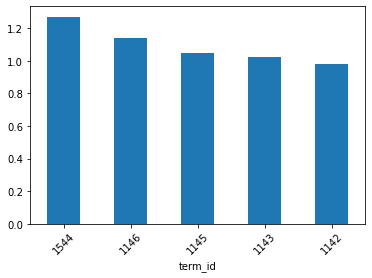

In [53]:
eig_pairs.exp_var.sort_values(ascending = False).head().plot.bar(rot = 45)

In [54]:
# pick top 10 components
comps = eig_pairs.sort_values('exp_var', ascending = False).head(10).reset_index()
comps.index.name = 'comp_id'
comps.index = ["PC{}".format(i) for i in comps.index.tolist()]

In [55]:
comps

term_id   eig_val         3         6         7         8        10  \
PC0     1544  0.011739 -0.003233 -0.003296 -0.003779  0.024332  0.000365   
PC1     1146  0.010499 -0.000037  0.007080 -0.003306 -0.000870 -0.002805   
PC2     1145  0.009706  0.006885  0.008799  0.000284 -0.018570 -0.003357   
PC3     1143  0.009398  0.006144  0.000515  0.001418  0.010640 -0.001397   
PC4     1142  0.009029  0.002048 -0.001032  0.001342  0.057374 -0.003607   
PC5     1141  0.008509 -0.007185  0.005529  0.003759  0.002646  0.001921   
PC6     1147  0.008137 -0.006246 -0.003122 -0.004038 -0.008056  0.002320   
PC7     1140  0.007727  0.010078 -0.000794  0.007116 -0.019066 -0.000501   
PC8     1138  0.007530 -0.001612  0.005790 -0.000345  0.013168 -0.007016   
PC9     1137  0.007327 -0.002346 -0.004098 -0.003413  0.023549  0.000085   

           11        12        13  ...      1138      1140      1147  \
PC0 -0.006357 -0.003378  0.006836  ...  0.000490  0.004479 -0.000783   
PC1 -0.012659 -0.003148 -0.013532  ... -0.008923  0.000205  0.002003   
PC2 -0.018318 -0.000069  0.011323  ...  0.001027 -0.000379 -0.002863   
PC3  0.019447  0.002182  0.015736  ... -0.001311 -0.000465  0.000031   
PC4  0.009773  0.002693  0.009065  ...  0.002712  0.008123  0.008462   
PC5 -0.015518  0.001765 -0.010579  ...  0.006698 -0.001364  0.002033   
PC6  0.002646  0.003426  0.006012  ...  0.001553  0.002076 -0.005619   
PC7 -0.010100  0.002135  0.000997  ...  0.001325 -0.004008  0.006984   
PC8  0.024370  0.002109  0.008539  ...  0.000990 -0.017791  0.000651   
PC9 -0.013391  0.004166  0.026892  ...  0.010954 -0.001795 -0.007324   

         1141      1142      1143      1145      1146      1544  exp_var  
PC0  0.001585 -0.013339 -0.004119 -0.001141  0.004343  0.004479     1.27  
PC1 -0.004718 -0.015812  0.000332 -0.003255 -0.004865  0.000205     1.14  
PC2  0.003463  0.004294 -0.001627 -0.001856  0.003476 -0.000379     1.05  
PC3  0.001809 -0.039589 -0.003621 -0.001224 -0.000137 -0.000465     1.02  
PC4  0.008408 -0.026370 -0.002934  0.003545 -0.000828  0.008123     0.98  
PC5  0.000519 -0.089618 -0.003692  0.001885 -0.000672 -0.001364     0.92  
PC6 -0.010846 -0.028681 -0.006059  0.001186  0.007885  0.002076     0.88  
PC7  0.006140  0.061255  0.008242 -0.004891  0.009838 -0.004008     0.84  
PC8 -0.001282  0.019364 -0.004757 -0.014938 -0.004017 -0.017791     0.82  
PC9  0.002284  0.048084  0.002423  0.005884  0.007335 -0.001795     0.79  

[10 rows x 1458 columns]

In [56]:
comps.to_csv('output files/chunked/comps_full.csv')

In [57]:
# inspect terms 
top_terms = [int(x) for x in eig_pairs.sort_values('exp_var', ascending = False).head(10).index]
vocab[vocab.term_id.isin(top_terms)].term_str

264        science
891          scale
951          score
953           seal
956          scene
960        schools
962        scratch
965     schoolwork
968           seat
1544          zone
Name: term_str, dtype: object

In [58]:
# show loadings 
loadings = comps[term_idx].T
loadings.index.name = 'term_id'
loadings.head().style.background_gradient()

In [59]:
loadings['term_str'] = loadings.apply(lambda x: vocab.loc[int(x.name)].term_str, 1)

In [60]:
l0_pos = loadings.sort_values('PC0', ascending = True).head(10).term_str.str.cat(sep = ' ')
l0_neg = loadings.sort_values('PC0', ascending = False).head(10).term_str.str.cat(sep = ' ')
l1_pos = loadings.sort_values('PC1', ascending = True).head(10).term_str.str.cat(sep = ' ')
l1_neg = loadings.sort_values('PC1', ascending = False).head(10).term_str.str.cat(sep = ' ')

In [61]:
print('Speakers PC0+', l0_pos)
print('Speakers PC0-', l0_neg)
print('Speakers PC1+', l1_pos)
print('Speakers PC1-', l1_neg)

Speakers PC0+ completing rings scale send early rachel onto interruption ours gave
Speakers PC0- technically peers nod later feeling compassion guess swing hey finding
Speakers PC1+ hey safely finding lastly voices technically success concern later tells
Speakers PC1- mode sure heard refresh true track could here under apologize


In [62]:
# project speakers onto new subspace
dcm = tfidf.dot(comps[term_idx].T).reset_index()
dcm

speaker_id       PC0       PC1       PC2       PC3       PC4       PC5  \
0        201_0  0.112750  0.300454  0.069141 -0.238746 -0.163880 -0.083554   
1        201_1  0.160648 -0.080272 -0.016434 -0.198503 -0.147157  0.140586   
2        201_2  0.002916 -0.002816 -0.059799 -0.116122 -0.150576  0.055090   
3        201_3  0.049426  0.006317 -0.094389 -0.059374 -0.114256  0.031290   
4        201_4  0.073794 -0.086559  0.015567 -0.119400 -0.009964 -0.019025   
..         ...       ...       ...       ...       ...       ...       ...   
436      360_0 -0.069883  0.155502  0.004972  0.094430  0.024396 -0.040221   
437      360_1  0.155645 -0.012282  0.039304  0.010566  0.182507 -0.062297   
438      360_2 -0.107508 -0.028774  0.033893 -0.012478  0.049414 -0.012641   
439      360_3 -0.082938 -0.027803 -0.148666  0.031327  0.058003 -0.016196   
440      360_4 -0.045358  0.014152  0.041716  0.037837  0.073301 -0.064218   

          PC6       PC7       PC8       PC9  
0   -0.035518  0.030982  0.073246 -0.014030  
1   -0.124072  0.043086  0.055022 -0.021904  
2   -0.087318  0.101645  0.037372 -0.012784  
3   -0.074377  0.089434 -0.004919 -0.043535  
4   -0.114916  0.068041  0.023559 -0.106052  
..        ...       ...       ...       ...  
436 -0.073991 -0.104962 -0.128366  0.089462  
437  0.055854 -0.096220 -0.001997  0.081278  
438 -0.092262  0.010162  0.003955  0.013124  
439 -0.011617 -0.035014  0.031995 -0.215623  
440 -0.026210 -0.084421 -0.012650 -0.045475  

[441 rows x 11 columns]

In [63]:
dcm['temp_speaker'] = dcm.speaker_id.apply(lambda x: int(x[:3]))
dcm = dcm.merge(survey, how = 'left', left_on = 'temp_speaker', right_on = 'speaker_id').drop(columns = ['temp_speaker', 'speaker_id_y']).rename(columns = {'speaker_id_x': 'speaker_id'})
dcm 

speaker_id       PC0       PC1       PC2       PC3       PC4       PC5  \
0        201_0  0.112750  0.300454  0.069141 -0.238746 -0.163880 -0.083554   
1        201_1  0.160648 -0.080272 -0.016434 -0.198503 -0.147157  0.140586   
2        201_2  0.002916 -0.002816 -0.059799 -0.116122 -0.150576  0.055090   
3        201_3  0.049426  0.006317 -0.094389 -0.059374 -0.114256  0.031290   
4        201_4  0.073794 -0.086559  0.015567 -0.119400 -0.009964 -0.019025   
..         ...       ...       ...       ...       ...       ...       ...   
436      360_0 -0.069883  0.155502  0.004972  0.094430  0.024396 -0.040221   
437      360_1  0.155645 -0.012282  0.039304  0.010566  0.182507 -0.062297   
438      360_2 -0.107508 -0.028774  0.033893 -0.012478  0.049414 -0.012641   
439      360_3 -0.082938 -0.027803 -0.148666  0.031327  0.058003 -0.016196   
440      360_4 -0.045358  0.014152  0.041716  0.037837  0.073301 -0.064218   

          PC6       PC7       PC8       PC9  mindfulness  
0   -0.035518  0.030982  0.073246 -0.014030            1  
1   -0.124072  0.043086  0.055022 -0.021904            1  
2   -0.087318  0.101645  0.037372 -0.012784            1  
3   -0.074377  0.089434 -0.004919 -0.043535            1  
4   -0.114916  0.068041  0.023559 -0.106052            1  
..        ...       ...       ...       ...          ...  
436 -0.073991 -0.104962 -0.128366  0.089462            0  
437  0.055854 -0.096220 -0.001997  0.081278            0  
438 -0.092262  0.010162  0.003955  0.013124            0  
439 -0.011617 -0.035014  0.031995 -0.215623            0  
440 -0.026210 -0.084421 -0.012650 -0.045475            0  

[441 rows x 12 columns]

In [64]:
dcm.to_csv('output files/chunked/dcm_full.csv')

In [65]:
import plotly_express as px
def vis_pcs(M, a, b, label = 'mindfulness', prefix = 'PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                     color = label, hover_name = 'speaker_id', marginal_x = 'box')
    fig.show()

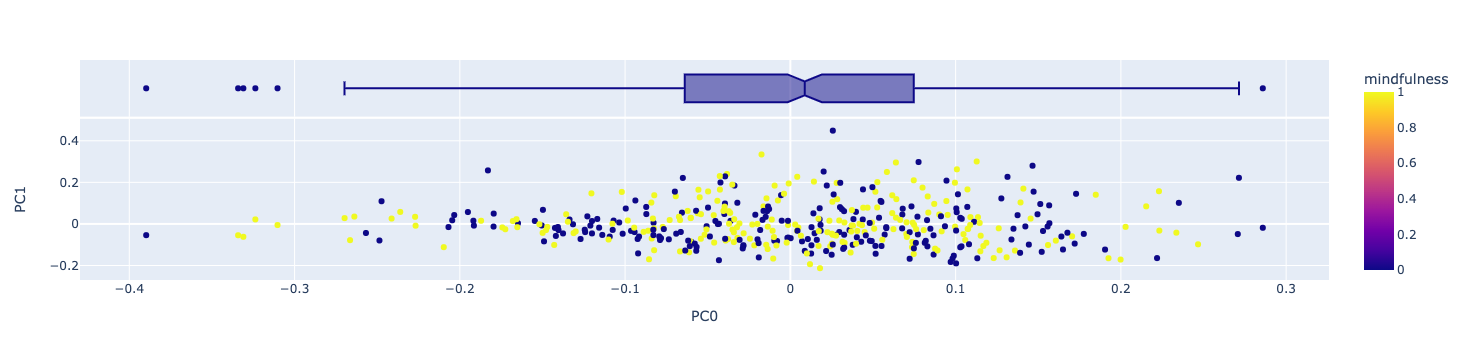

In [66]:
vis_pcs(dcm, 0, 1)

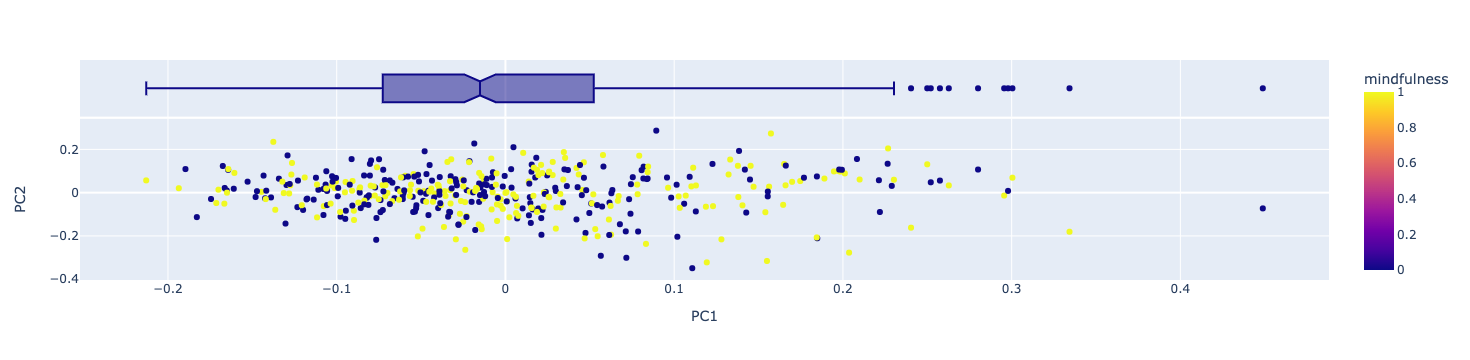

In [67]:
vis_pcs(dcm, 1, 2)

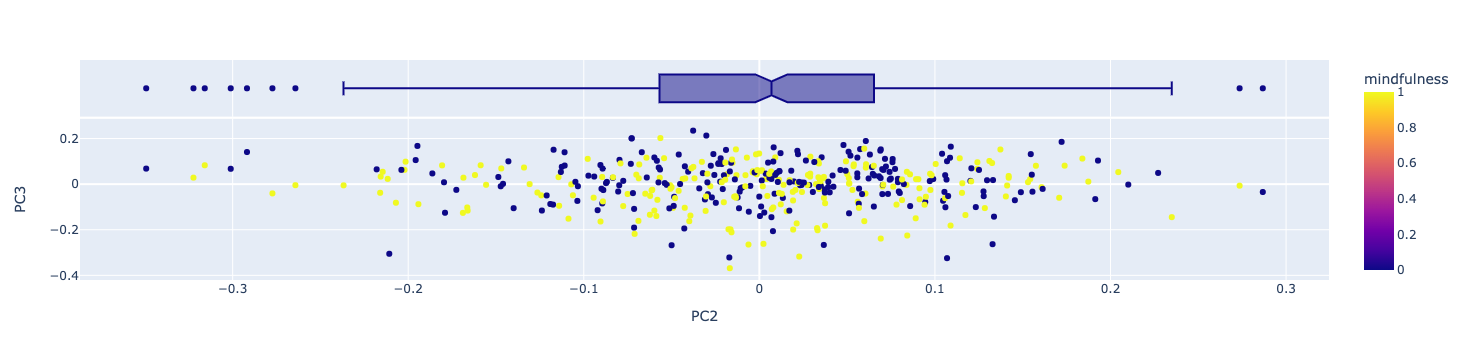

In [68]:
vis_pcs(dcm, 2, 3)

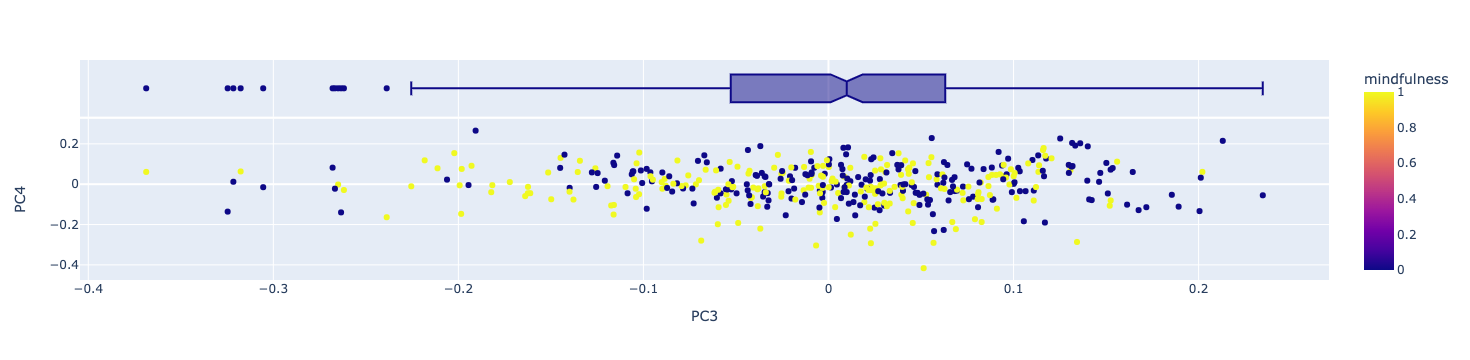

In [69]:
vis_pcs(dcm, 3, 4)

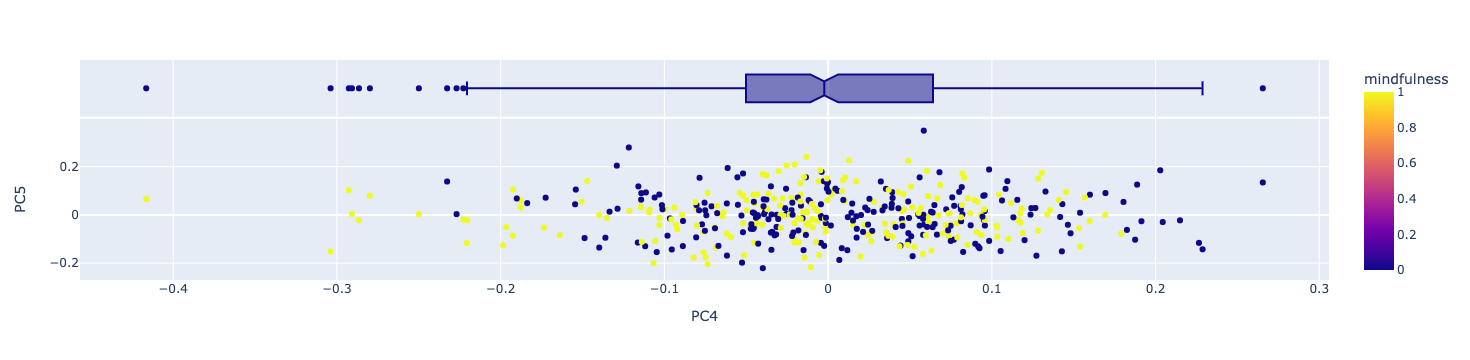

In [70]:
vis_pcs(dcm, 4, 5)

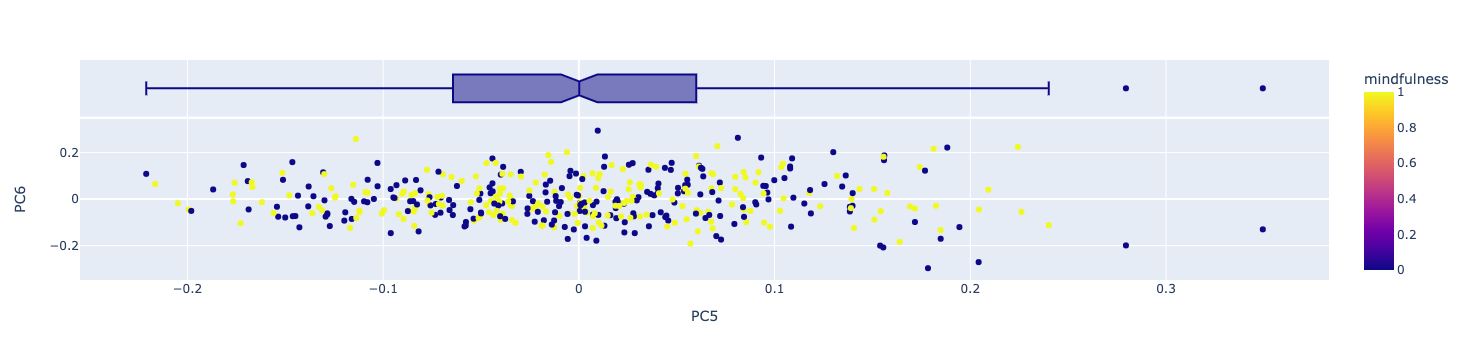

In [71]:
vis_pcs(dcm, 5, 6)

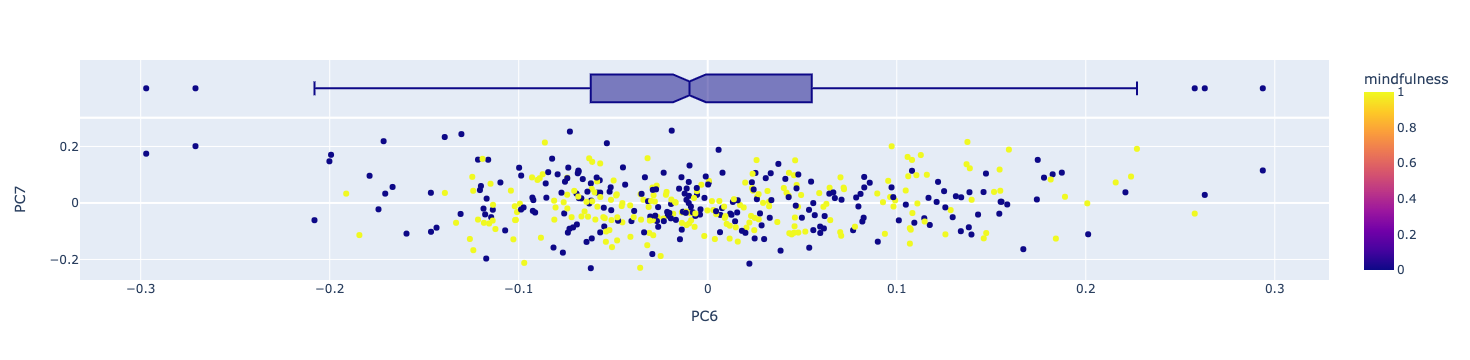

In [72]:
vis_pcs(dcm, 6, 7)

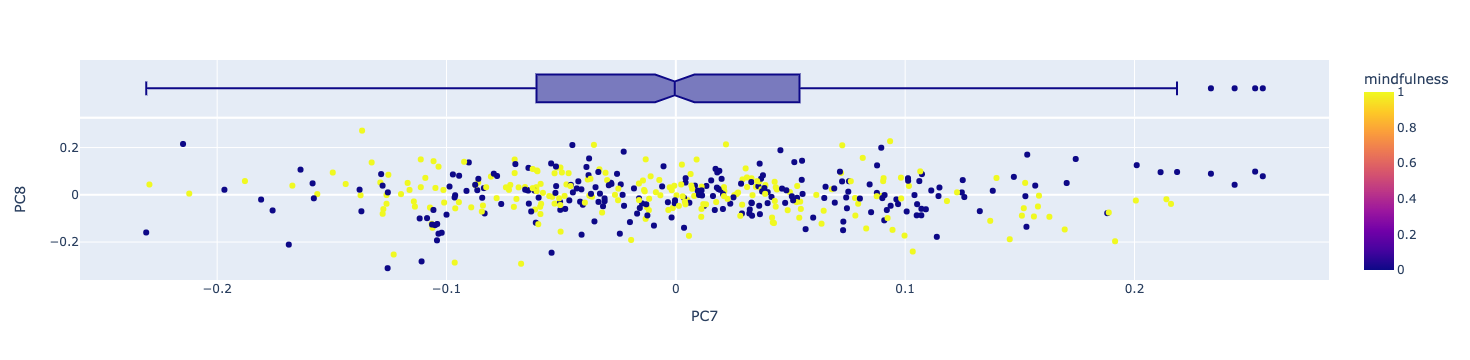

In [73]:
vis_pcs(dcm, 7, 8)

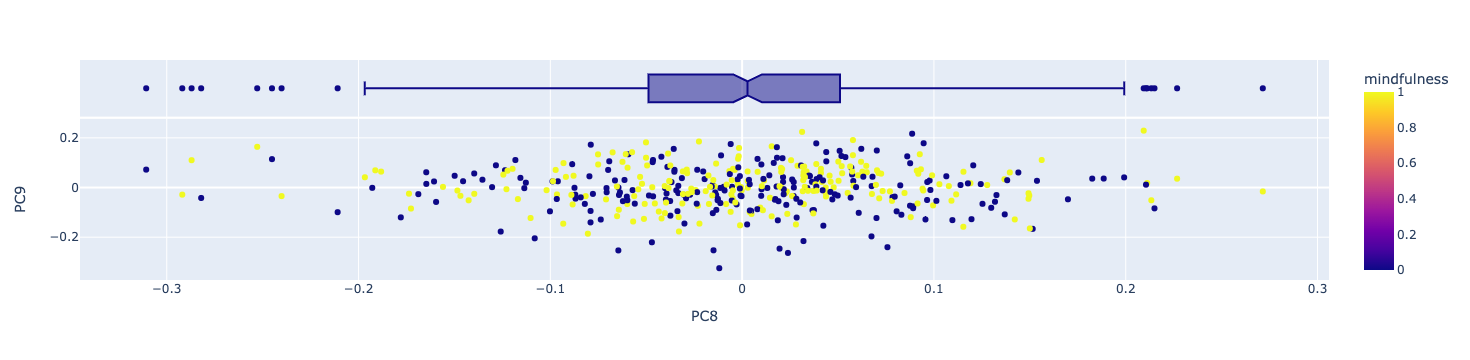

In [74]:
vis_pcs(dcm, 8, 9)

### Similarity

In [75]:
tfidf.head()

term_id         3         6         7         8         10        11    \
speaker_id                                                               
201_0      -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
201_1      -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
201_2      -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
201_3      -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
201_4      -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   

term_id         12        13        14        15    ...      1137      1138  \
speaker_id                                          ...                       
201_0      -0.000472 -0.001198 -0.001015 -0.003724  ... -0.000904 -0.000483   
201_1      -0.000472 -0.001198 -0.001015 -0.003724  ... -0.000904 -0.000483   
201_2      -0.000472 -0.001198 -0.001015 -0.003724  ... -0.000904 -0.000483   
201_3      -0.000472 -0.001198 -0.001015 -0.003724  ... -0.000904 -0.000483   
201_4      -0.000472 -0.001198 -0.001015 -0.003724  ... -0.000904 -0.000483   

term_id         1140      1147      1141      1142      1143      1145  \
speaker_id                                                               
201_0      -0.000458 -0.000614 -0.000492 -0.007913 -0.000583 -0.000391   
201_1      -0.000458 -0.000614 -0.000492 -0.007913 -0.000583 -0.000391   
201_2      -0.000458 -0.000614 -0.000492 -0.007913 -0.000583 -0.000391   
201_3      -0.000458 -0.000614 -0.000492  0.122076 -0.000583 -0.000391   
201_4      -0.000458 -0.000614 -0.000492 -0.007913 -0.000583 -0.000391   

term_id         1146      1544  
speaker_id                      
201_0      -0.000402 -0.000458  
201_1      -0.000402 -0.000458  
201_2      -0.000402 -0.000458  
201_3      -0.000402 -0.000458  
201_4      -0.000402 -0.000458  

[5 rows x 1455 columns]

In [76]:
lib.head()

book_file
speaker_id                              
201_0       201_1.24.20_S_SC_Chunk_0.txt
201_1       201_1.24.20_S_SC_Chunk_1.txt
201_2       201_1.24.20_S_SC_Chunk_2.txt
201_3       201_1.24.20_S_SC_Chunk_3.txt
201_4       201_1.24.20_S_SC_Chunk_4.txt

In [77]:
from scipy.linalg import norm 
l0 = tfidf.astype('bool').astype('int')
l1 = tfidf.apply(lambda x: x / x.sum(), 1)
l2 = tfidf.apply(lambda x: x/ norm(x), 1)

In [78]:
pairs = pd.DataFrame(index = pd.MultiIndex.from_product([tfidf.index.tolist(), tfidf.index.tolist()])).reset_index()

In [79]:
pairs = pairs[pairs.level_0 < pairs.level_1].set_index(['level_0', 'level_1'])
pairs.index.names = ['speaker_a', 'speaker_b']

In [80]:
pairs.head()

Empty DataFrame
Columns: []
Index: [(201_0, 201_1), (201_0, 201_2), (201_0, 201_3), (201_0, 201_4), (201_0, 202_0)]

In [81]:
pairs.shape

(97020, 0)

In [82]:
from scipy.spatial.distance import pdist
pairs['cityblock'] = pdist(tfidf, 'cityblock')
pairs['euclidean'] = pdist(tfidf, 'euclidean')
pairs['cosine'] = pdist(tfidf, 'cosine')
pairs['jaccard'] = pdist(l0, 'jaccard')
pairs['dice'] = pdist(l0, 'dice')
pairs['js'] = pdist(l1, 'jensenshannon')
pairs['euclidean2'] = pdist(l2, 'euclidean')
pairs['js2'] = pdist(tfidf, 'jensenshannon')
pairs.head()

cityblock  euclidean    cosine  jaccard  dice   js  \
speaker_a speaker_b                                                       
201_0     201_1       9.632156   1.246272  0.867963      0.0   0.0  inf   
          201_2       8.530099   1.273081  0.889038      0.0   0.0  inf   
          201_3       9.232484   1.230343  0.824848      0.0   0.0  inf   
          201_4      10.031104   1.290161  0.912812      0.0   0.0  inf   
          202_0       8.946694   1.284110  0.904318      0.0   0.0  inf   

                     euclidean2  js2  
speaker_a speaker_b                   
201_0     201_1        1.317545  inf  
          201_2        1.333445  inf  
          201_3        1.284405  inf  
          201_4        1.351156  inf  
          202_0        1.344855  inf

In [83]:
pairs

cityblock  euclidean    cosine  jaccard  dice   js  \
speaker_a speaker_b                                                       
201_0     201_1       9.632156   1.246272  0.867963      0.0   0.0  inf   
          201_2       8.530099   1.273081  0.889038      0.0   0.0  inf   
          201_3       9.232484   1.230343  0.824848      0.0   0.0  inf   
          201_4      10.031104   1.290161  0.912812      0.0   0.0  inf   
          202_0       8.946694   1.284110  0.904318      0.0   0.0  inf   
...                        ...        ...       ...      ...   ...  ...   
360_1     360_3      11.102119   1.356847  1.019215      0.0   0.0  inf   
          360_4      11.641821   1.315045  0.955017      0.0   0.0  inf   
360_2     360_3       9.744611   1.375523  0.989772      0.0   0.0  inf   
          360_4      11.032162   1.386308  1.003114      0.0   0.0  inf   
360_3     360_4       9.662606   1.351244  0.953859      0.0   0.0  inf   

                     euclidean2  js2  
speaker_a speaker_b                   
201_0     201_1        1.317545  inf  
          201_2        1.333445  inf  
          201_3        1.284405  inf  
          201_4        1.351156  inf  
          202_0        1.344855  inf  
...                         ...  ...  
360_1     360_3        1.427736  inf  
          360_4        1.382040  inf  
360_2     360_3        1.406962  inf  
          360_4        1.416414  inf  
360_3     360_4        1.381202  inf  

[97020 rows x 8 columns]

In [84]:
pairs.to_csv('output files/chunked/pairs.csv')

In [85]:
ho_lookup = pd.read_csv('holdout_samples_lookup.csv')

In [86]:
ho_lookup.head()

studyid  mindfulness  300s  holdout
0      349            1     1        0
1      314            1     1        0
2      223            1     0        0
3      207            0     0        0
4      333            0     1        0

In [87]:
tfidf = tfidf.reset_index()
tfidf['temp_speaker'] = tfidf.speaker_id.apply(lambda x: int(x[:3]))
tfidf = tfidf.merge(ho_lookup, how = 'left', left_on = 'temp_speaker', right_on = 'studyid') \
    .drop(['studyid', '300s', 'temp_speaker'], axis = 1)
tfidf['label'] = tfidf.apply(lambda x: "{}-{}".format(x.speaker_id, str(x.mindfulness)), 1)
tfidf.head()

speaker_id         3         6         7         8        10        11  \
0      201_0 -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
1      201_1 -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
2      201_2 -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
3      201_3 -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   
4      201_4 -0.000863 -0.000557 -0.000479 -0.006644 -0.000404 -0.003533   

         12        13        14  ...      1147      1141      1142      1143  \
0 -0.000472 -0.001198 -0.001015  ... -0.000614 -0.000492 -0.007913 -0.000583   
1 -0.000472 -0.001198 -0.001015  ... -0.000614 -0.000492 -0.007913 -0.000583   
2 -0.000472 -0.001198 -0.001015  ... -0.000614 -0.000492 -0.007913 -0.000583   
3 -0.000472 -0.001198 -0.001015  ... -0.000614 -0.000492  0.122076 -0.000583   
4 -0.000472 -0.001198 -0.001015  ... -0.000614 -0.000492 -0.007913 -0.000583   

       1145      1146      1544  mindfulness  holdout    label  
0 -0.000391 -0.000402 -0.000458            1        0  201_0-1  
1 -0.000391 -0.000402 -0.000458            1        0  201_1-1  
2 -0.000391 -0.000402 -0.000458            1        0  201_2-1  
3 -0.000391 -0.000402 -0.000458            1        0  201_3-1  
4 -0.000391 -0.000402 -0.000458            1        0  201_4-1  

[5 rows x 1459 columns]

In [88]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 25)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = tfidf.label.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

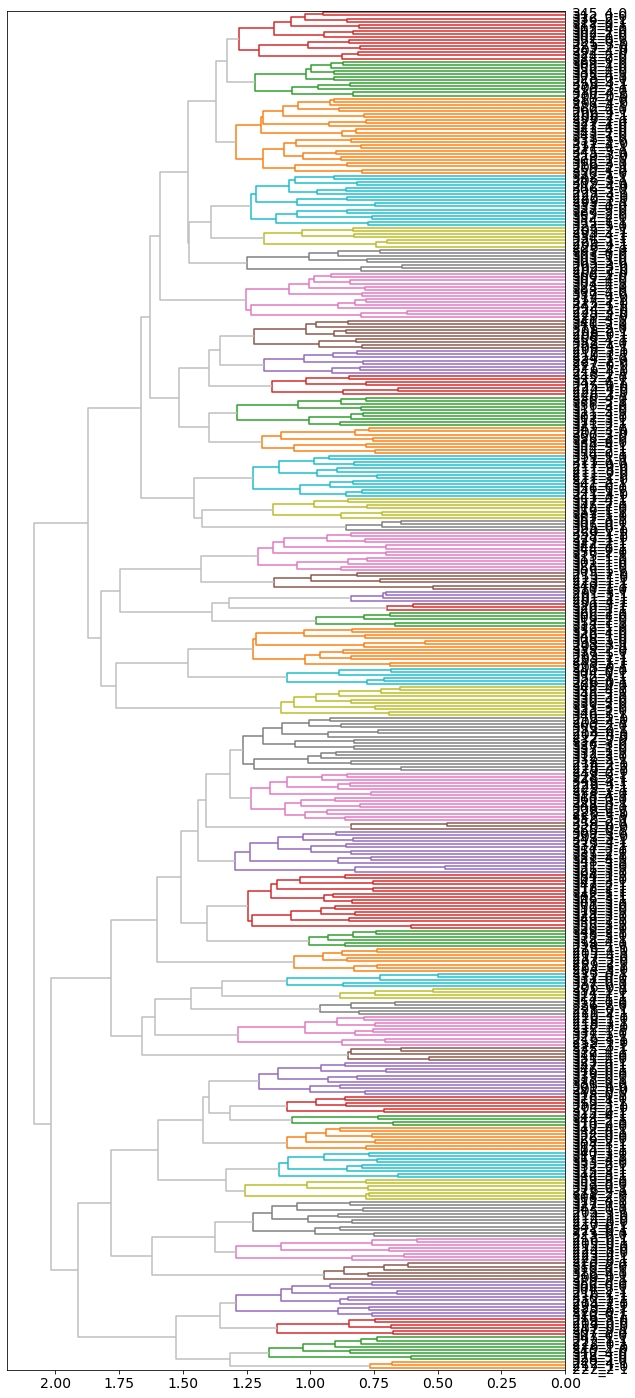

In [89]:
hca(pairs.cosine, color_thresh = 1.3)

/Users/gracelyons/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2872: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.



<Figure size 432x288 with 0 Axes>

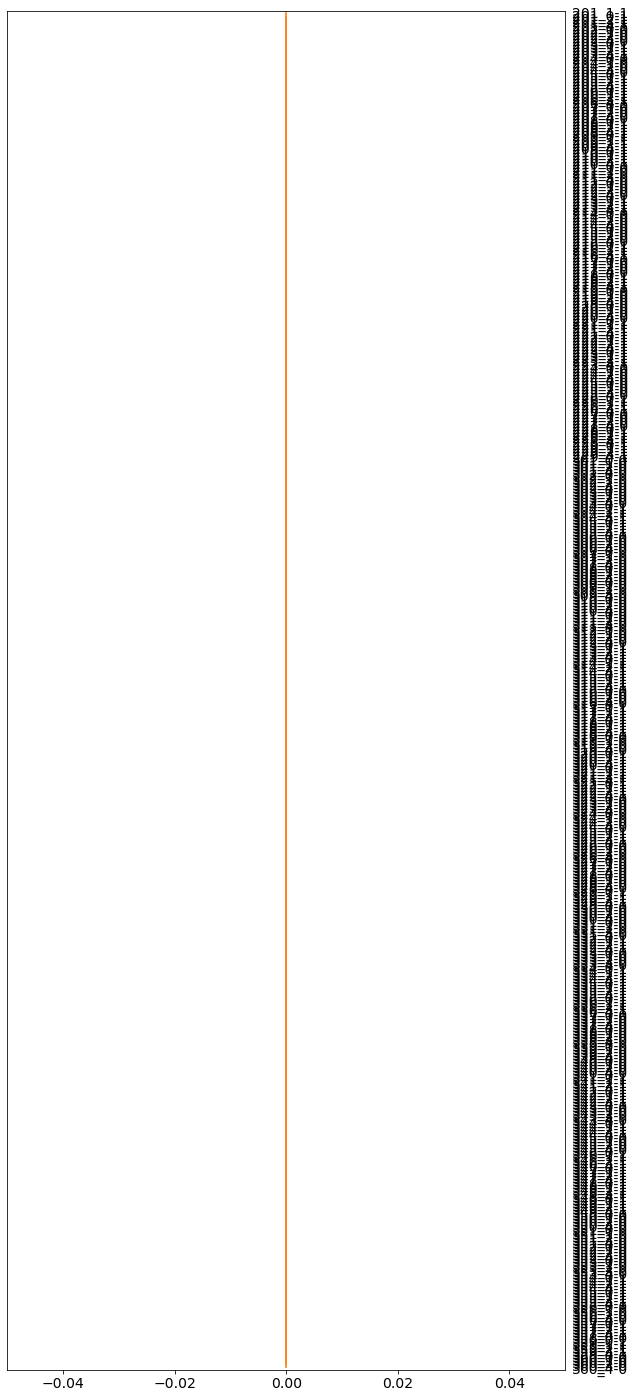

In [90]:
hca(pairs.jaccard, color_thresh = 0.9)

<Figure size 432x288 with 0 Axes>

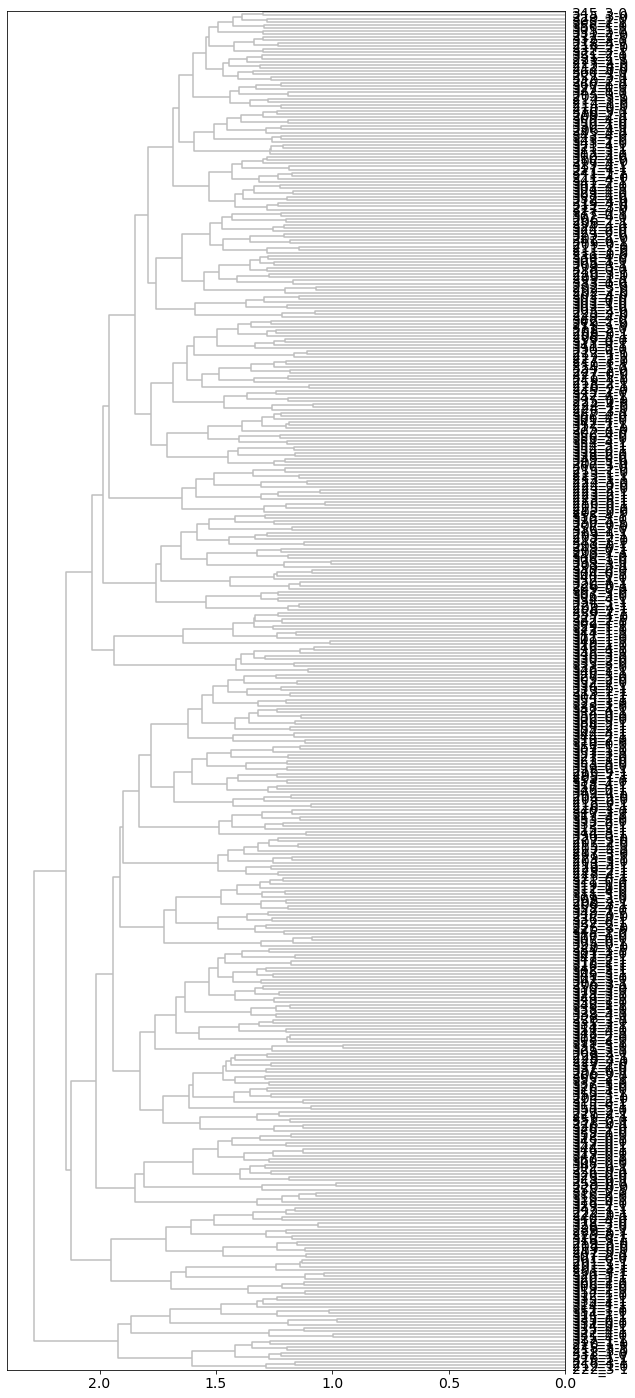

In [91]:
hca(pairs.euclidean, color_thresh = .05)

<Figure size 432x288 with 0 Axes>

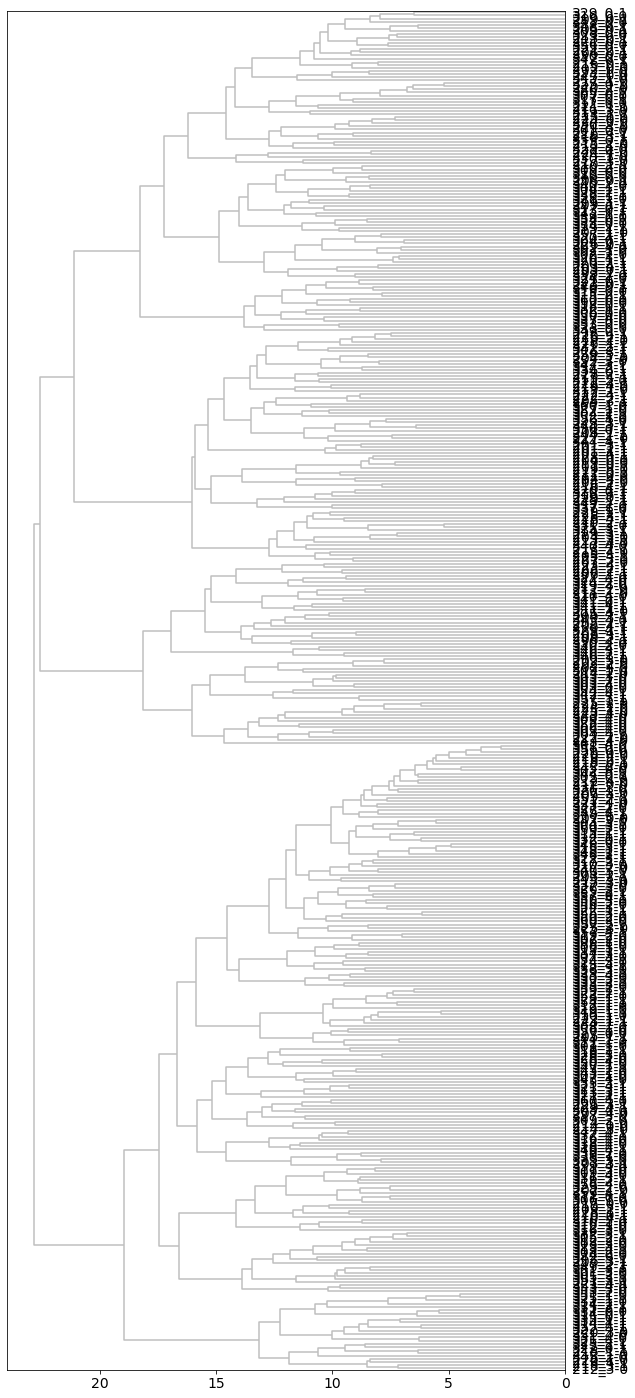

In [92]:
hca(pairs.cityblock, color_thresh = 0.6)

<Figure size 432x288 with 0 Axes>

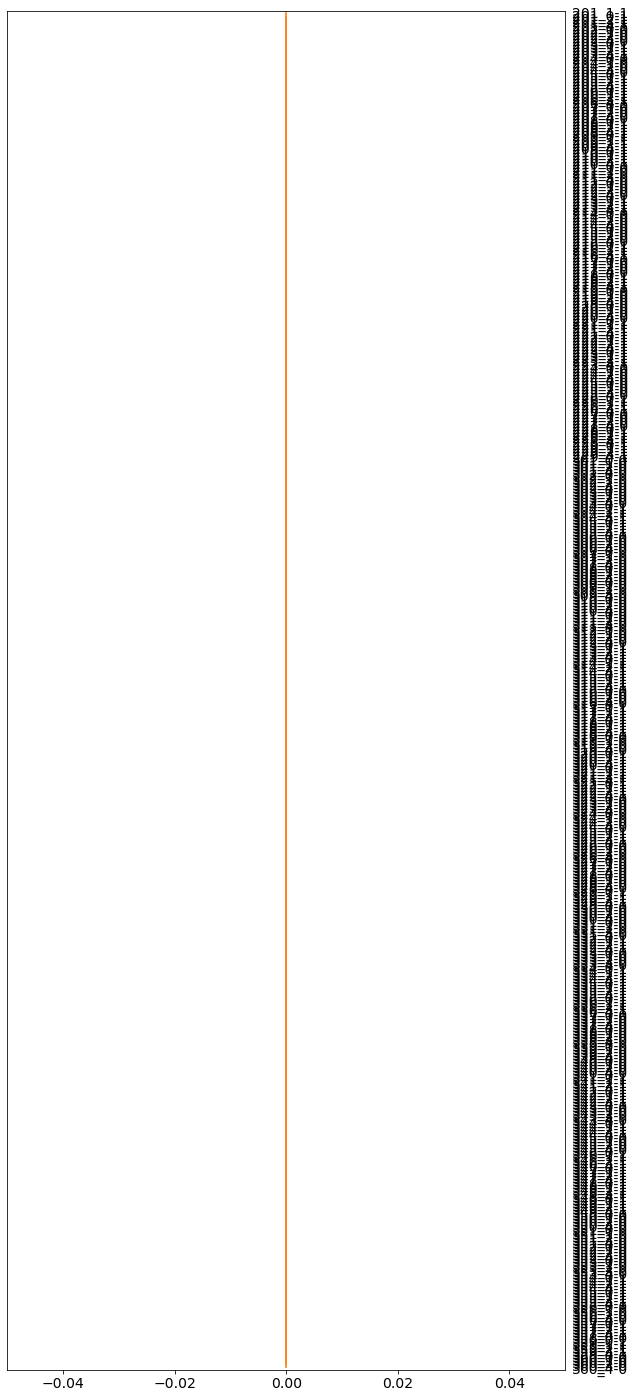

In [93]:
hca(pairs.dice, color_thresh = .8)

<Figure size 432x288 with 0 Axes>

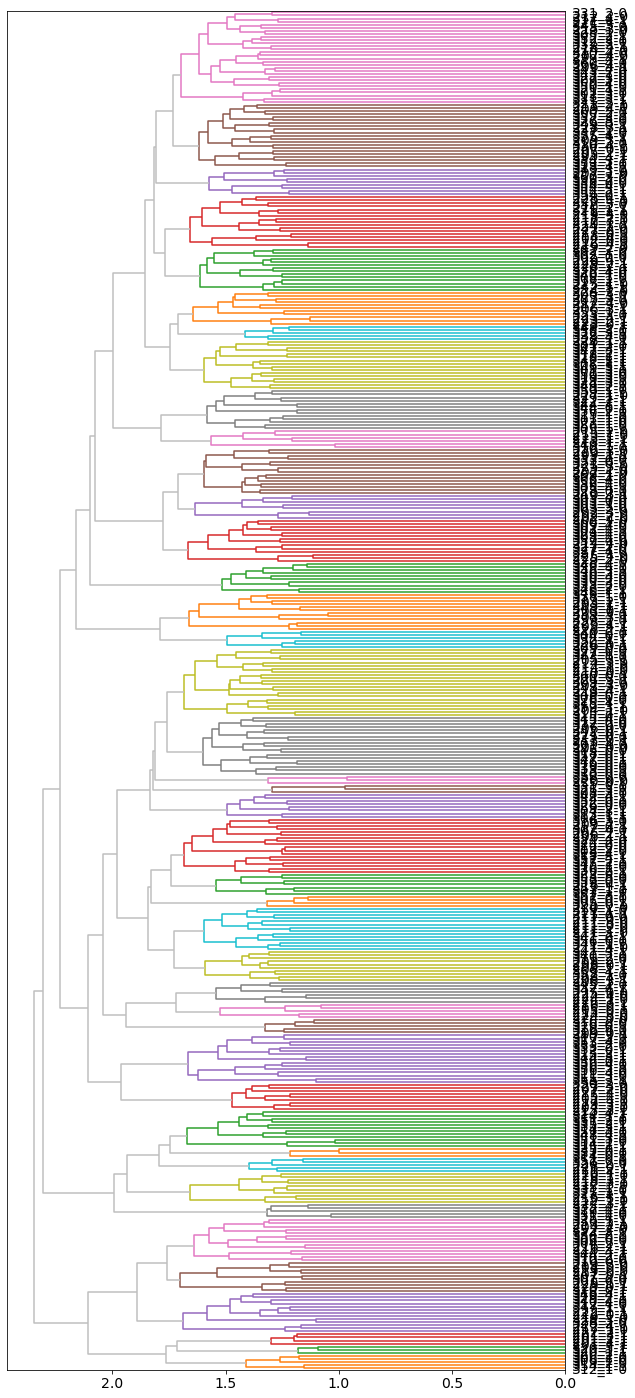

In [94]:
hca(pairs.euclidean2, color_thresh = 1.7)

#### k means

In [95]:
from sklearn.cluster import KMeans

In [96]:
speakers = tfidf[['speaker_id', 'mindfulness', 'label']]
speakers.head()

speaker_id  mindfulness    label
0      201_0            1  201_0-1
1      201_1            1  201_1-1
2      201_2            1  201_2-1
3      201_3            1  201_3-1
4      201_4            1  201_4-1

In [97]:
tfidf = tfidf.drop('label', axis = 1).set_index(['speaker_id', 'mindfulness'])

In [98]:
tfidf

3         6         7         8        10  \
speaker_id mindfulness                                                     
201_0      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_1      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_2      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_3      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_4      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
...                          ...       ...       ...       ...       ...   
360_0      0           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
360_1      0           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
360_2      0           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
360_3      0           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
360_4      0           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   

                              11        12        13        14        15  ...  \
speaker_id mindfulness                                                    ...   
201_0      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_1      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_2      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_3      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_4      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
...                          ...       ...       ...       ...       ...  ...   
360_0      0           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
360_1      0           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
360_2      0           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
360_3      0            0.328564 -0.000472 -0.001198 -0.001015 -0.003724  ...   
360_4      0           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   

                            1138      1140      1147      1141      1142  \
speaker_id mindfulness                                                     
201_0      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
201_1      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
201_2      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
201_3      1           -0.000483 -0.000458 -0.000614 -0.000492  0.122076   
201_4      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
...                          ...       ...       ...       ...       ...   
360_0      0           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
360_1      0           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
360_2      0           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
360_3      0           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
360_4      0           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   

                            1143      1145      1146      1544  holdout  
speaker_id mindfulness                                                   
201_0      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_1      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_2      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_3      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_4      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
...                          ...       ...       ...       ...      ...  
360_0      0           -0.000583 -0.000391 -0.000402 -0.000458        1  
360_1      0           -0.000583 -0.000391 -0.000402 -0.000458        1  
360_2      0           -0.000583 -0.000391 -0.000402 -0.000458        1  
360_3      0           -0.000583 -0.000391 -0.000402 -0.000458        1  
360_4      0           -0.000583 -0.000391 -0.000402 -0.000458        1  

[441 rows x 1456 columns]

In [99]:
n_clusters = 2

In [100]:
speakers['y_raw'] = KMeans(n_clusters).fit_predict(tfidf)
speakers['y_L0'] = KMeans(n_clusters).fit_predict(l0)
speakers['y_L1'] = KMeans(n_clusters).fit_predict(l1)
speakers['y_L2'] = KMeans(n_clusters).fit_predict(l2)

/Users/gracelyons/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/gracelyons/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.



In [101]:
speakers.head()

speaker_id  mindfulness    label  y_raw  y_L0  y_L1  y_L2
0      201_0            1  201_0-1      0     0     0     1
1      201_1            1  201_1-1      0     0     0     1
2      201_2            1  201_2-1      0     0     0     0
3      201_3            1  201_3-1      0     0     0     1
4      201_4            1  201_4-1      0     0     0     1

In [102]:
speakers.to_csv('output files/chunked/k_means.csv')

In [103]:
speakers.sort_values('y_raw').style.background_gradient(cmap = 'viridis')

In [104]:
speakers.sort_values('y_L0').style.background_gradient(cmap = 'viridis')

In [105]:
speakers.sort_values('y_L1').style.background_gradient(cmap = 'viridis')

In [106]:
speakers.sort_values('y_L2').style.background_gradient(cmap = 'viridis')

### LDA

In [107]:
n_terms = 4000
n_topics = 30
max_iter = 5
OHCO = ['speaker_id']

In [108]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
%matplotlib inline

In [109]:
token.head()

speaker_id  line_num  sent_num  token_num      pos_tuple  pos token_str  \
0      201_0         1         0          0     (Good, JJ)   JJ      Good   
1      201_0         1         0          1  (morning, NN)   NN   morning   
2      201_0         1         0          2    (class, NN)   NN     class   
3      201_0         1         2          0     (How, WRB)  WRB       How   
4      201_0         1         2          1     (are, VBP)  VBP       are   

  term_str  term_id  mindfulness  
0     good      538            1  
1  morning      828            1  
2    class      230            1  
3      how      609            1  
4      are       85            1

In [110]:
speakers = token[token.pos.str.match(r'^NNS?$')]\
            .groupby(['speaker_id']).term_str.apply(lambda x: ' '.join(x)).to_frame()\
            .rename(columns = {'term_str': 'speaker_str'})

In [111]:
speakers.head()

speaker_str
speaker_id                                                   
201_0       morning class today today expectations groups ...
201_1       share thought hand others share listen please ...
201_2       um group worries ideas trouble share ex uh exp...
201_3       yeah idea idea brain break stretching body cou...
201_4       expectations group expectation hand li uh shar...

In [112]:
tfv = CountVectorizer(max_features = n_terms, stop_words = 'english')
tf = tfv.fit_transform(speakers.speaker_str)
terms = tfv.get_feature_names_out()

In [113]:
lda = LDA(n_components = n_topics, max_iter = max_iter, learning_offset = 50., random_state = 0)

In [114]:
theta = pd.DataFrame(lda.fit_transform(tf), index = speakers.index)
theta.columns.name = 'topic_id'

In [115]:
theta.sample(20).style.background_gradient()

In [116]:
theta.to_csv('output files/chunked/theta_lda.csv')

In [117]:
phi = pd.DataFrame(lda.components_, columns = terms)
phi.index.name = 'topic_id'
phi.columns.name = 'term_str'

In [118]:
phi.T.head().style.background_gradient()

In [119]:
phi.to_csv('output files/chunked/phi_lda.csv')

In [120]:
topics = phi.stack().to_frame().rename(columns = {0: 'weight'})\
            .groupby('topic_id').apply(lambda x: x.weight.sort_values(ascending = False).head(10)
                                                   .reset_index().drop('topic_id', axis = 1).term_str)

In [121]:
topics

term_str             0            1            2           3             4  \
topic_id                                                                     
0                break        share        thing          na       problem   
1              morning         idea  expectation       thank     everybody   
2              teacher         hand      respect   classroom  expectations   
3                 book       report        thing    question         today   
4            classroom         norm        right     speaker       example   
5                share      example        hands        norm          time   
6                 hand         work      science     choices         right   
7                class  expectation       phones  classmates      question   
8                class        right       people       rules     classroom   
9                right         hand    classroom       break        people   
10        expectations        today    classroom       class          hand   
11                okay        norms         cell      people          kind   
12               norms    classroom        class        norm     attention   
13                time        class         norm      phones          okay   
14           classroom        class        norms        kind         words   
15           classroom        share       people       ideas         class   
16               right    classroom        class         lot          time   
17               class     homework        right        norm         norms   
18               hands        class       school       stuff          okay   
19               class        share         time        kind          idea   
20           classroom         time       things       thing         hands   
21              movies        space       people       phone         right   
22           classroom        norms        today       class          guys   
23               night       school        class          um          year   
24                 mom         norm      example   classroom          kind   
25               right         kind         hand        care         norms   
26            question    listening          way          na     attention   
27              school     vacation         time     hallway         norms   
28           classroom        norms      anybody        hand        things   
29                kind          bit         okay   classroom        people   

term_str          5             6             7              8             9  
topic_id                                                                      
0              kind          hand         today          group          talk  
1              hand           yep          care          sense         mmhmm  
2              time         share   expectation           norm          eyes  
3           answers     attention         break         answer        boring  
4             class          task       anybody         skills          eyes  
5             norms         stuff          okay           hand        pencil  
6         classroom    discussion          time         finger         looks  
7              cell          hand          okay           norm        things  
8              hand         ideas       example         things          year  
9         attention        school        voices   expectations        things  
10             kind         ideas           way           guys            um  
11             norm        phones         topic         school          turn  
12             kind          okay         today         school       respect  
13            norms         phone         right          share         thing  
14             hand          okay         rules        weekend         share  
15           things        school    classmates       homework          body  
16             rule         thing  conversation          notes       weekend  
17

In [122]:
topics.to_csv('output files/chunked/topics_lda.csv')

In [123]:
topics['label'] = topics.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')),1)

In [124]:
topics.label

topic_id
0              0 break share thing na problem kind hand
1     1 morning idea expectation thank everybody han...
2     2 teacher hand respect classroom expectations ...
3     3 book report thing question today answers att...
4     4 classroom norm right speaker example class task
5           5 share example hands norm time norms stuff
6     6 hand work science choices right classroom di...
7     7 class expectation phones classmates question...
8       8 class right people rules classroom hand ideas
9     9 right hand classroom break people attention ...
10    10 expectations today classroom class hand kin...
11           11 okay norms cell people kind norm phones
12    12 norms classroom class norm attention kind okay
13           13 time class norm phones okay norms phone
14        14 classroom class norms kind words hand okay
15    15 classroom share people ideas class things s...
16         16 right classroom class lot time rule thing
17         17 class homework right norm

In [125]:
topics['speaker_weight_sum'] = theta.sum()

<AxesSubplot:ylabel='label'>

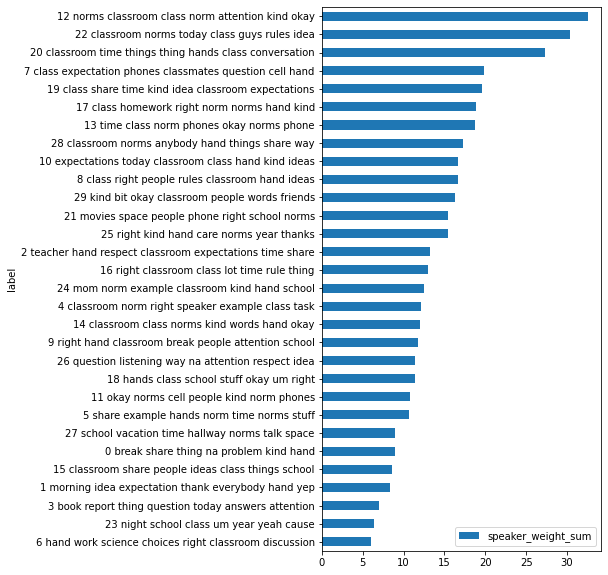

In [126]:
topics.sort_values('speaker_weight_sum', ascending = True).plot.barh(y = 'speaker_weight_sum', x = 'label', figsize = (5, 10))

### NRC Analysis

In [127]:
nrc = pd.read_csv('NRC.csv')

In [128]:
nrc.head()

word sentiment
0     abacus     trust
1    abandon      fear
2    abandon  negative
3    abandon   sadness
4  abandoned     anger

In [129]:
sentiments = nrc.sentiment.unique()

In [130]:
d = {}
for sent in sentiments:
    d[f"df_{sent}"] = nrc[nrc.sentiment == sent].reset_index().drop('index', axis = 1)
#d   

In [131]:
d['df_trust'].head()

word sentiment
0      abacus     trust
1       abbot     trust
2  absolution     trust
3   abundance     trust
4    academic     trust

In [132]:
token.head()

speaker_id  line_num  sent_num  token_num      pos_tuple  pos token_str  \
0      201_0         1         0          0     (Good, JJ)   JJ      Good   
1      201_0         1         0          1  (morning, NN)   NN   morning   
2      201_0         1         0          2    (class, NN)   NN     class   
3      201_0         1         2          0     (How, WRB)  WRB       How   
4      201_0         1         2          1     (are, VBP)  VBP       are   

  term_str  term_id  mindfulness  
0     good      538            1  
1  morning      828            1  
2    class      230            1  
3      how      609            1  
4      are       85            1

In [133]:
for sent in sentiments:
    token[sent] = token.apply(lambda x: 1 if x.term_str in d[f"df_{sent}"].word.values else 0, axis = 1)
    
token.head()

speaker_id  line_num  sent_num  token_num      pos_tuple  pos token_str  \
0      201_0         1         0          0     (Good, JJ)   JJ      Good   
1      201_0         1         0          1  (morning, NN)   NN   morning   
2      201_0         1         0          2    (class, NN)   NN     class   
3      201_0         1         2          0     (How, WRB)  WRB       How   
4      201_0         1         2          1     (are, VBP)  VBP       are   

  term_str  term_id  mindfulness  trust  fear  negative  sadness  anger  \
0     good      538            1      1     0         0        0      0   
1  morning      828            1      0     0         0        0      0   
2    class      230            1      0     0         0        0      0   
3      how      609            1      0     0         0        0      0   
4      are       85            1      0     0         0        0      0   

   surprise  positive  disgust  joy  anticipation  
0         1         1        0    1             1  
1         0         0        0    0             0  
2         0         0        0    0             0  
3         0         0        0    0             0  
4         0         0        0    0             0

In [134]:
token_grouped = token.groupby('speaker_id').sum().reset_index().drop(['line_num', 'sent_num', 'token_num', 'term_id'], axis = 1)

In [135]:
token_grouped.head()

speaker_id  mindfulness  trust  fear  negative  sadness  anger  surprise  \
0      201_0           57      4     0         1        0      0         3   
1      201_1          132      7     2         4        2      0         1   
2      201_2           81      2     1         2        1      0         0   
3      201_3           92      2     0         2        0      0         1   
4      201_4          107      4     1         5        1      2         1   

   positive  disgust  joy  anticipation  
0         4        0    4             4  
1         9        0    4             6  
2         6        0    2             3  
3         5        0    3             2  
4         6        1    4             3

In [136]:
lengths = token.groupby('speaker_id').size().values

In [137]:
token_grouped['length'] = lengths

In [138]:
token_grouped.head()

speaker_id  mindfulness  trust  fear  negative  sadness  anger  surprise  \
0      201_0           57      4     0         1        0      0         3   
1      201_1          132      7     2         4        2      0         1   
2      201_2           81      2     1         2        1      0         0   
3      201_3           92      2     0         2        0      0         1   
4      201_4          107      4     1         5        1      2         1   

   positive  disgust  joy  anticipation  length  
0         4        0    4             4      57  
1         9        0    4             6     132  
2         6        0    2             3      81  
3         5        0    3             2      92  
4         6        1    4             3     107

In [139]:
token_grouped_normalized = pd.DataFrame()
for sent in sentiments:
    token_grouped_normalized[f'{sent}_norm'] = token_grouped.apply(lambda x: (x[sent]/ x['length']) if x[sent] != 0 else 0, axis = 1)

In [140]:
token_grouped_normalized['speaker_id'] = token_grouped.speaker_id

In [141]:
token_grouped_normalized.head()

trust_norm  fear_norm  negative_norm  sadness_norm  anger_norm  \
0    0.070175   0.000000       0.017544      0.000000    0.000000   
1    0.053030   0.015152       0.030303      0.015152    0.000000   
2    0.024691   0.012346       0.024691      0.012346    0.000000   
3    0.021739   0.000000       0.021739      0.000000    0.000000   
4    0.037383   0.009346       0.046729      0.009346    0.018692   

   surprise_norm  positive_norm  disgust_norm  joy_norm  anticipation_norm  \
0       0.052632       0.070175      0.000000  0.070175           0.070175   
1       0.007576       0.068182      0.000000  0.030303           0.045455   
2       0.000000       0.074074      0.000000  0.024691           0.037037   
3       0.010870       0.054348      0.000000  0.032609           0.021739   
4       0.009346       0.056075      0.009346  0.037383           0.028037   

  speaker_id  
0      201_0  
1      201_1  
2      201_2  
3      201_3  
4      201_4

In [142]:
survey.head()

speaker_id  mindfulness
0         201            1
1         202            0
2         203            1
3         204            0
4         205            1

In [143]:
token_grouped_normalized['temp_id'] = token_grouped_normalized.speaker_id.apply(lambda x: int(x[:3]))
token_grouped_normalized = token_grouped_normalized.merge(survey, how = 'left', left_on = 'temp_id', right_on = 'speaker_id').drop(columns = ['speaker_id_y']).rename(columns = {'speaker_id_x': 'speaker_id'})

In [144]:
ho_lookup.head()

studyid  mindfulness  300s  holdout
0      349            1     1        0
1      314            1     1        0
2      223            1     0        0
3      207            0     0        0
4      333            0     1        0

In [145]:
token_grouped_normalized = token_grouped_normalized.merge(ho_lookup, how = 'left', left_on = 'temp_id', right_on = 'studyid').drop(['studyid', 'mindfulness_y', '300s', 'temp_id'], axis = 1).rename(columns = {'mindfulness_x': 'mindfulness'}).set_index('speaker_id')

In [146]:
token_grouped_normalized.head()

trust_norm  fear_norm  negative_norm  sadness_norm  anger_norm  \
speaker_id                                                                   
201_0         0.070175   0.000000       0.017544      0.000000    0.000000   
201_1         0.053030   0.015152       0.030303      0.015152    0.000000   
201_2         0.024691   0.012346       0.024691      0.012346    0.000000   
201_3         0.021739   0.000000       0.021739      0.000000    0.000000   
201_4         0.037383   0.009346       0.046729      0.009346    0.018692   

            surprise_norm  positive_norm  disgust_norm  joy_norm  \
speaker_id                                                         
201_0            0.052632       0.070175      0.000000  0.070175   
201_1            0.007576       0.068182      0.000000  0.030303   
201_2            0.000000       0.074074      0.000000  0.024691   
201_3            0.010870       0.054348      0.000000  0.032609   
201_4            0.009346       0.056075      0.009346  0.037383   

            anticipation_norm  mindfulness  holdout  
speaker_id                                           
201_0                0.070175            1        0  
201_1                0.045455            1        0  
201_2                0.037037            1        0  
201_3                0.021739            1        0  
201_4                0.028037            1        0

In [147]:
token_grouped_normalized.to_csv('output files/chunked/nrc_normalized.csv')

### Full Regression Testing

In [148]:
nrc = token_grouped_normalized
nrc.head()

trust_norm  fear_norm  negative_norm  sadness_norm  anger_norm  \
speaker_id                                                                   
201_0         0.070175   0.000000       0.017544      0.000000    0.000000   
201_1         0.053030   0.015152       0.030303      0.015152    0.000000   
201_2         0.024691   0.012346       0.024691      0.012346    0.000000   
201_3         0.021739   0.000000       0.021739      0.000000    0.000000   
201_4         0.037383   0.009346       0.046729      0.009346    0.018692   

            surprise_norm  positive_norm  disgust_norm  joy_norm  \
speaker_id                                                         
201_0            0.052632       0.070175      0.000000  0.070175   
201_1            0.007576       0.068182      0.000000  0.030303   
201_2            0.000000       0.074074      0.000000  0.024691   
201_3            0.010870       0.054348      0.000000  0.032609   
201_4            0.009346       0.056075      0.009346  0.037383   

            anticipation_norm  mindfulness  holdout  
speaker_id                                           
201_0                0.070175            1        0  
201_1                0.045455            1        0  
201_2                0.037037            1        0  
201_3                0.021739            1        0  
201_4                0.028037            1        0

In [149]:
phi.head()

term_str  abilities   ability       act    action  activities  activity  \
topic_id                                                                  
0          0.033333  0.033333  0.033333  0.033333    0.033333  0.033333   
1          0.033333  0.033333  0.033333  0.033333    1.033333  1.033333   
2          0.033333  0.033333  0.033333  0.033333    0.033333  0.033333   
3          0.033333  0.033333  0.033333  0.033333    0.033333  0.033333   
4          0.033333  0.033333  0.033333  0.033333    0.033333  0.033333   

term_str       add   address    adults    advice  ...   worries     worry  \
topic_id                                          ...                       
0         0.033333  1.033333  0.033333  0.033333  ...  0.033333  1.033333   
1         0.033333  0.033333  0.033333  0.033333  ...  0.033333  0.033333   
2         0.033333  0.033333  0.033333  0.033333  ...  0.033333  0.033333   
3         0.033333  0.033333  0.033333  0.033333  ...  0.033333  0.033333   
4         0.033333  0.033333  0.033333  0.033333  ...  1.033333  0.033333   

term_str   writing      yall       yay      yeah      year     years  \
topic_id                                                               
0         0.033333  0.033877  0.033333  0.033333  0.283197  0.033333   
1         0.033333  0.033333  0.033333  1.999663  0.033333  0.033333   
2         0.033333  0.033333  0.033333  0.033333  0.033333  0.033333   
3         0.033333  1.082333  0.033333  0.033333  0.033333  0.033333   
4         0.033333  0.033333  0.033333  0.033333  2.033333  0.033333   

term_str       yep      zone  
topic_id                      
0         0.033333  0.033333  
1         3.033333  0.033333  
2         0.033333  0.033333  
3         0.033333  0.033333  
4         0.033333  0.033333  

[5 rows x 658 columns]

In [150]:
theta.head()

topic_id          0         1         2         3         4         5   \
speaker_id                                                               
201_0       0.003333  0.003333  0.003333  0.003333  0.003333  0.235075   
201_1       0.001754  0.949123  0.001754  0.001754  0.001754  0.001754   
201_2       0.002564  0.002564  0.002564  0.002564  0.002564  0.002564   
201_3       0.001754  0.001754  0.001754  0.001754  0.001754  0.001754   
201_4       0.002222  0.002222  0.002222  0.002222  0.002222  0.002222   

topic_id          6         7         8         9   ...        20        21  \
speaker_id                                          ...                       
201_0       0.003333  0.003333  0.003333  0.003333  ...  0.003333  0.003333   
201_1       0.001754  0.001754  0.001754  0.001754  ...  0.001754  0.001754   
201_2       0.002564  0.002564  0.002564  0.002564  ...  0.002564  0.002564   
201_3       0.001754  0.001754  0.001754  0.001754  ...  0.001754  0.001754   
201_4       0.002222  0.002222  0.002222  0.002222  ...  0.002222  0.002222   

topic_id          22        23        24        25        26        27  \
speaker_id                                                               
201_0       0.003333  0.003333  0.003333  0.003333  0.003333  0.003333   
201_1       0.001754  0.001754  0.001754  0.001754  0.001754  0.001754   
201_2       0.002564  0.002564  0.002564  0.002564  0.002564  0.002564   
201_3       0.001754  0.001754  0.001754  0.001754  0.001754  0.001754   
201_4       0.002222  0.002222  0.002222  0.369952  0.002222  0.002222   

topic_id          28        29  
speaker_id                      
201_0       0.003333  0.003333  
201_1       0.001754  0.001754  
201_2       0.002564  0.002564  
201_3       0.001754  0.001754  
201_4       0.002222  0.002222  

[5 rows x 30 columns]

In [151]:
topics.head()

term_str          0       1            2          3             4        5  \
topic_id                                                                     
0             break   share        thing         na       problem     kind   
1           morning    idea  expectation      thank     everybody     hand   
2           teacher    hand      respect  classroom  expectations     time   
3              book  report        thing   question         today  answers   
4         classroom    norm        right    speaker       example    class   

term_str          6            7       8       9  \
topic_id                                           
0              hand        today   group    talk   
1               yep         care   sense   mmhmm   
2             share  expectation    norm    eyes   
3         attention        break  answer  boring   
4              task      anybody  skills    eyes   

term_str                                              label  \
topic_id                                                      
0                  0 break share thing na problem kind hand   
1         1 morning idea expectation thank everybody han...   
2         2 teacher hand respect classroom expectations ...   
3         3 book report thing question today answers att...   
4         4 classroom norm right speaker example class task   

term_str  speaker_weight_sum  
topic_id                      
0                   8.941424  
1                   8.315338  
2                  13.220453  
3                   7.048561  
4                  12.110507

In [152]:
k_means = speakers
k_means.head()

speaker_str
speaker_id                                                   
201_0       morning class today today expectations groups ...
201_1       share thought hand others share listen please ...
201_2       um group worries ideas trouble share ex uh exp...
201_3       yeah idea idea brain break stretching body cou...
201_4       expectations group expectation hand li uh shar...

In [153]:
pairs.head()

cityblock  euclidean    cosine  jaccard  dice   js  \
speaker_a speaker_b                                                       
201_0     201_1       9.632156   1.246272  0.867963      0.0   0.0  inf   
          201_2       8.530099   1.273081  0.889038      0.0   0.0  inf   
          201_3       9.232484   1.230343  0.824848      0.0   0.0  inf   
          201_4      10.031104   1.290161  0.912812      0.0   0.0  inf   
          202_0       8.946694   1.284110  0.904318      0.0   0.0  inf   

                     euclidean2  js2  
speaker_a speaker_b                   
201_0     201_1        1.317545  inf  
          201_2        1.333445  inf  
          201_3        1.284405  inf  
          201_4        1.351156  inf  
          202_0        1.344855  inf

In [154]:
dcm.head()

speaker_id       PC0       PC1       PC2       PC3       PC4       PC5  \
0      201_0  0.112750  0.300454  0.069141 -0.238746 -0.163880 -0.083554   
1      201_1  0.160648 -0.080272 -0.016434 -0.198503 -0.147157  0.140586   
2      201_2  0.002916 -0.002816 -0.059799 -0.116122 -0.150576  0.055090   
3      201_3  0.049426  0.006317 -0.094389 -0.059374 -0.114256  0.031290   
4      201_4  0.073794 -0.086559  0.015567 -0.119400 -0.009964 -0.019025   

        PC6       PC7       PC8       PC9  mindfulness  
0 -0.035518  0.030982  0.073246 -0.014030            1  
1 -0.124072  0.043086  0.055022 -0.021904            1  
2 -0.087318  0.101645  0.037372 -0.012784            1  
3 -0.074377  0.089434 -0.004919 -0.043535            1  
4 -0.114916  0.068041  0.023559 -0.106052            1

In [155]:
comps.head()

term_id   eig_val         3         6         7         8        10  \
PC0     1544  0.011739 -0.003233 -0.003296 -0.003779  0.024332  0.000365   
PC1     1146  0.010499 -0.000037  0.007080 -0.003306 -0.000870 -0.002805   
PC2     1145  0.009706  0.006885  0.008799  0.000284 -0.018570 -0.003357   
PC3     1143  0.009398  0.006144  0.000515  0.001418  0.010640 -0.001397   
PC4     1142  0.009029  0.002048 -0.001032  0.001342  0.057374 -0.003607   

           11        12        13  ...      1138      1140      1147  \
PC0 -0.006357 -0.003378  0.006836  ...  0.000490  0.004479 -0.000783   
PC1 -0.012659 -0.003148 -0.013532  ... -0.008923  0.000205  0.002003   
PC2 -0.018318 -0.000069  0.011323  ...  0.001027 -0.000379 -0.002863   
PC3  0.019447  0.002182  0.015736  ... -0.001311 -0.000465  0.000031   
PC4  0.009773  0.002693  0.009065  ...  0.002712  0.008123  0.008462   

         1141      1142      1143      1145      1146      1544  exp_var  
PC0  0.001585 -0.013339 -0.004119 -0.001141  0.004343  0.004479     1.27  
PC1 -0.004718 -0.015812  0.000332 -0.003255 -0.004865  0.000205     1.14  
PC2  0.003463  0.004294 -0.001627 -0.001856  0.003476 -0.000379     1.05  
PC3  0.001809 -0.039589 -0.003621 -0.001224 -0.000137 -0.000465     1.02  
PC4  0.008408 -0.026370 -0.002934  0.003545 -0.000828  0.008123     0.98  

[5 rows x 1458 columns]

In [156]:
tfidf_pca = tfidf
tfidf_pca.head()

3         6         7         8        10  \
speaker_id mindfulness                                                     
201_0      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_1      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_2      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_3      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   
201_4      1           -0.000863 -0.000557 -0.000479 -0.006644 -0.000404   

                              11        12        13        14        15  ...  \
speaker_id mindfulness                                                    ...   
201_0      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_1      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_2      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_3      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   
201_4      1           -0.003533 -0.000472 -0.001198 -0.001015 -0.003724  ...   

                            1138      1140      1147      1141      1142  \
speaker_id mindfulness                                                     
201_0      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
201_1      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
201_2      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   
201_3      1           -0.000483 -0.000458 -0.000614 -0.000492  0.122076   
201_4      1           -0.000483 -0.000458 -0.000614 -0.000492 -0.007913   

                            1143      1145      1146      1544  holdout  
speaker_id mindfulness                                                   
201_0      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_1      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_2      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_3      1           -0.000583 -0.000391 -0.000402 -0.000458        0  
201_4      1           -0.000583 -0.000391 -0.000402 -0.000458        0  

[5 rows x 1456 columns]

In [157]:
survey.head()

speaker_id  mindfulness
0         201            1
1         202            0
2         203            1
3         204            0
4         205            1

In [158]:
ho_lookup.head()

studyid  mindfulness  300s  holdout
0      349            1     1        0
1      314            1     1        0
2      223            1     0        0
3      207            0     0        0
4      333            0     1        0

In [159]:
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [160]:
nrc.head(1)

trust_norm  fear_norm  negative_norm  sadness_norm  anger_norm  \
speaker_id                                                                   
201_0         0.070175        0.0       0.017544           0.0         0.0   

            surprise_norm  positive_norm  disgust_norm  joy_norm  \
speaker_id                                                         
201_0            0.052632       0.070175           0.0  0.070175   

            anticipation_norm  mindfulness  holdout  
speaker_id                                           
201_0                0.070175            1        0

In [161]:
data = nrc

In [162]:
data.head()

trust_norm  fear_norm  negative_norm  sadness_norm  anger_norm  \
speaker_id                                                                   
201_0         0.070175   0.000000       0.017544      0.000000    0.000000   
201_1         0.053030   0.015152       0.030303      0.015152    0.000000   
201_2         0.024691   0.012346       0.024691      0.012346    0.000000   
201_3         0.021739   0.000000       0.021739      0.000000    0.000000   
201_4         0.037383   0.009346       0.046729      0.009346    0.018692   

            surprise_norm  positive_norm  disgust_norm  joy_norm  \
speaker_id                                                         
201_0            0.052632       0.070175      0.000000  0.070175   
201_1            0.007576       0.068182      0.000000  0.030303   
201_2            0.000000       0.074074      0.000000  0.024691   
201_3            0.010870       0.054348      0.000000  0.032609   
201_4            0.009346       0.056075      0.009346  0.037383   

            anticipation_norm  mindfulness  holdout  
speaker_id                                           
201_0                0.070175            1        0  
201_1                0.045455            1        0  
201_2                0.037037            1        0  
201_3                0.021739            1        0  
201_4                0.028037            1        0

In [163]:
dcm['temp_id'] = dcm.speaker_id.apply(lambda x: int(x[:3]))
dcm = dcm.merge(ho_lookup, how = 'left', left_on = 'temp_id', right_on = 'studyid') \
    .drop(['mindfulness_y', 'studyid', '300s', 'temp_id'], axis = 1) \
    .rename(columns = {'mindfulness_x': 'mindfulness'})

In [164]:
dcm.head(1)

speaker_id      PC0       PC1       PC2       PC3      PC4       PC5  \
0      201_0  0.11275  0.300454  0.069141 -0.238746 -0.16388 -0.083554   

        PC6       PC7       PC8      PC9  mindfulness  holdout  
0 -0.035518  0.030982  0.073246 -0.01403            1        0

In [165]:
data = data.merge(dcm, on = ['speaker_id', 'mindfulness', 'holdout'])

In [166]:
data.head()

speaker_id  trust_norm  fear_norm  negative_norm  sadness_norm  anger_norm  \
0      201_0    0.070175   0.000000       0.017544      0.000000    0.000000   
1      201_1    0.053030   0.015152       0.030303      0.015152    0.000000   
2      201_2    0.024691   0.012346       0.024691      0.012346    0.000000   
3      201_3    0.021739   0.000000       0.021739      0.000000    0.000000   
4      201_4    0.037383   0.009346       0.046729      0.009346    0.018692   

   surprise_norm  positive_norm  disgust_norm  joy_norm  ...       PC0  \
0       0.052632       0.070175      0.000000  0.070175  ...  0.112750   
1       0.007576       0.068182      0.000000  0.030303  ...  0.160648   
2       0.000000       0.074074      0.000000  0.024691  ...  0.002916   
3       0.010870       0.054348      0.000000  0.032609  ...  0.049426   
4       0.009346       0.056075      0.009346  0.037383  ...  0.073794   

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.300454  0.069141 -0.238746 -0.163880 -0.083554 -0.035518  0.030982   
1 -0.080272 -0.016434 -0.198503 -0.147157  0.140586 -0.124072  0.043086   
2 -0.002816 -0.059799 -0.116122 -0.150576  0.055090 -0.087318  0.101645   
3  0.006317 -0.094389 -0.059374 -0.114256  0.031290 -0.074377  0.089434   
4 -0.086559  0.015567 -0.119400 -0.009964 -0.019025 -0.114916  0.068041   

        PC8       PC9  
0  0.073246 -0.014030  
1  0.055022 -0.021904  
2  0.037372 -0.012784  
3 -0.004919 -0.043535  
4  0.023559 -0.106052  

[5 rows x 23 columns]

In [167]:
feature_list = [feat for feat in data.columns if feat not in ['mindfulness', 'speaker_id', 'holdout']]

In [168]:
ttest_results = pd.DataFrame()

for feat in feature_list:
    df_0 = data[data['mindfulness'] == 0]
    df_1 = data[data['mindfulness'] == 1]
    
    temp_results = stats.ttest_ind(a = df_0[feat],
                                   b = df_1[feat],
                                   equal_var = False)
    
    df_temp = pd.DataFrame({'feature': feat,
                            'mean_0': df_0[feat].mean(),
                            'mean_1': df_1[feat].mean(),
                            't_stat': temp_results[0],
                            'p_value': temp_results[1]},
                           index = [0])
    
    ttest_results = pd.concat([ttest_results, df_temp], axis = 0)

In [169]:
ttest_results.reset_index(inplace = True, drop = True)

In [170]:
ttest_results.sort_values('p_value', inplace = True)
ttest_results

feature    mean_0    mean_1    t_stat   p_value
13                PC3  0.013574 -0.014269  3.044085  0.002474
14                PC4  0.011048 -0.011614  2.511987  0.012372
19                PC9 -0.009259  0.009732 -2.348582  0.019291
17                PC7  0.007044 -0.007405  1.731741  0.084022
0          trust_norm  0.038001  0.033593  1.724780  0.085317
11                PC1 -0.007266  0.007638 -1.528352  0.127149
4          anger_norm  0.003440  0.002340  1.303444  0.193278
6       positive_norm  0.064533  0.061150  1.098464  0.272614
16                PC6 -0.004177  0.004391 -1.000319  0.317711
8            joy_norm  0.028226  0.026318  0.791603  0.429021
12                PC2  0.002620 -0.002754  0.571199  0.568160
9   anticipation_norm  0.029950  0.028723  0.501507  0.616267
3        sadness_norm  0.009915  0.010632 -0.481694  0.630265
1           fear_norm  0.009750  0.010410 -0.467607  0.640303
2       negative_norm  0.013781  0.014508 -0.427024  0.669572
5       surprise_norm  0.014330  0.015223 -0.411599  0.680837
10                PC0  0.001626 -0.001709  0.322685  0.747088
18                PC8 -0.000956  0.001004 -0.236739  0.812970
15                PC5 -0.000298  0.000314 -0.069568  0.944569
7        disgust_norm  0.001130  0.001152 -0.034720  0.972325

In [171]:
top_feats = ttest_results[ttest_results.p_value < 0.15].feature.to_list()

In [172]:
top_feats

['PC3', 'PC4', 'PC9', 'PC7', 'trust_norm', 'PC1']

In [173]:
df = data[['speaker_id', 'mindfulness', 'holdout', 'PC3', 'PC4', 'PC9', 'PC7', 'trust_norm', 'PC1']]
df.head()

speaker_id  mindfulness  holdout       PC3       PC4       PC9       PC7  \
0      201_0            1        0 -0.238746 -0.163880 -0.014030  0.030982   
1      201_1            1        0 -0.198503 -0.147157 -0.021904  0.043086   
2      201_2            1        0 -0.116122 -0.150576 -0.012784  0.101645   
3      201_3            1        0 -0.059374 -0.114256 -0.043535  0.089434   
4      201_4            1        0 -0.119400 -0.009964 -0.106052  0.068041   

   trust_norm       PC1  
0    0.070175  0.300454  
1    0.053030 -0.080272  
2    0.024691 -0.002816  
3    0.021739  0.006317  
4    0.037383 -0.086559

/Users/gracelyons/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/gracelyons/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/gracelyons/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for 

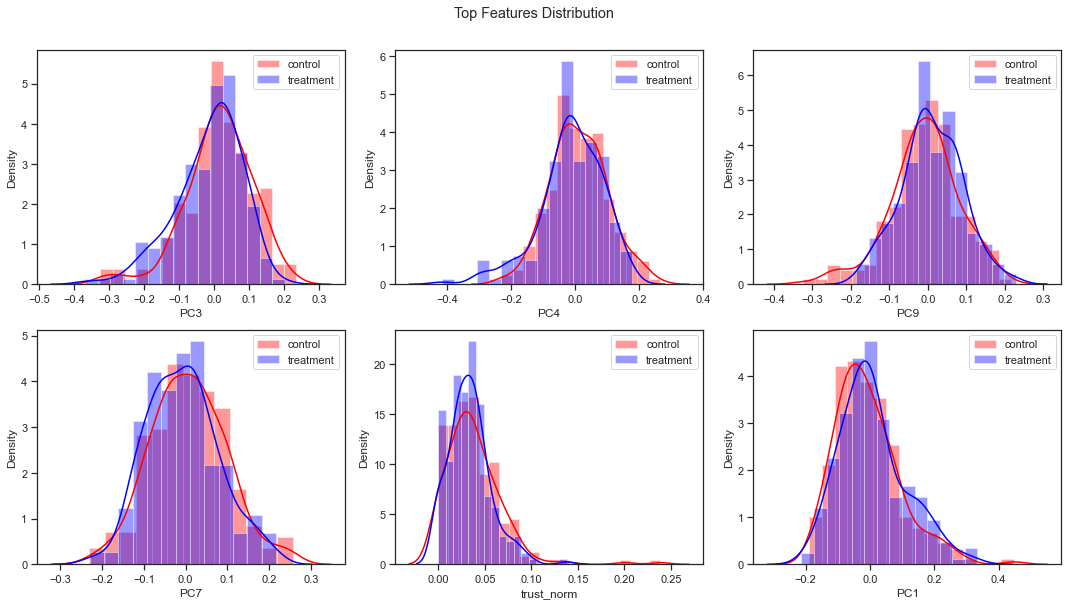

In [174]:
import seaborn as sns
sns.set(style = 'ticks')
fig = plt.figure(figsize = (15,20))
j = 0
for i in top_feats:
    plt.subplot(5, 3, j+1)
    j += 1
    sns.distplot(df[i][df['mindfulness']==0], color = 'red', label = 'control')
    sns.distplot(df[i][df['mindfulness']==1], color = 'blue', label = 'treatment')
    plt.legend(loc = 'best')
fig.suptitle('Top Features Distribution')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)
plt.show()

In [175]:
X_train = df[df['holdout'] == 0].drop(['mindfulness', 'speaker_id', 'holdout'], axis = 1)
y_train = df[df['holdout'] == 0]['mindfulness']
X_test = df[df['holdout'] == 1].drop(['mindfulness', 'speaker_id', 'holdout'], axis = 1)
y_test = df[df['holdout'] == 1]['mindfulness']

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [177]:
models = []

def classification_models(X_train, X_test, y_train, y_test):
    
    models.append(('Logistic Regression', LogisticRegression() ))
    models.append( ('SVM', SVC()) )
    models.append( ('Naive Bayes', GaussianNB()) )
    models.append( ('KNN', KNeighborsClassifier()) )
    
    model_outcomes = []
    model_names = []
    
    for name, model in models:
        results = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')
        
        model_outcomes.append(results)
        model_names.append(name)
        
        print(name, results.mean())

In [178]:
classification_models(X_train, X_test, y_train, y_test)

Logistic Regression 0.6012072434607646
SVM 0.5811267605633802
Naive Bayes 0.566841046277666
KNN 0.5870422535211267


In [179]:
for name, model in models:
    trainedmodel = model.fit(X_train,y_train)
    
    # prediction
    ypredict = trainedmodel.predict(X_test)
    
    acc = accuracy_score(y_test,ypredict)
    classreport = classification_report(y_test,ypredict)
    confMat = confusion_matrix(y_test,ypredict)
    
    print('Model Type: {}'.format(name))
    
    print('The accuracy: {}'.format(acc))
    print('The Classification Report:\n {}'.format(classreport))
    print('The Confusion Matrix:\n {}'.format(confMat))
    print('\n************')

Model Type: Logistic Regression
The accuracy: 0.5
The Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.78      0.61        45
           1       0.50      0.22      0.31        45

    accuracy                           0.50        90
   macro avg       0.50      0.50      0.46        90
weighted avg       0.50      0.50      0.46        90

The Confusion Matrix:
 [[35 10]
 [35 10]]

************
Model Type: SVM
The accuracy: 0.45555555555555555
The Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.51      0.48        45
           1       0.45      0.40      0.42        45

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.46      0.45        90

The Confusion Matrix:
 [[23 22]
 [27 18]]

************
Model Type: Naive Bayes
The accuracy: 0.5555555555555556
The Classification Re